<a href="https://colab.research.google.com/github/paularedondosastre/Mineria-de-datos/blob/main/Copia_de_Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final
<center><h1><b>Análisis de tendencias criminales</b></h1></center>
<center><h1>Un Enfoque de Clustering y Reglas de Asociación con Datos del FBI 2022</h1></center>

Grupo A04

Lucía Casas, Marta Herraiz, Alba López, Paula Redondo


In [1]:
pip install --upgrade nbconvert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.4/257.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: mistune
    Found existing installation: mistune 0.8.4
    Uninstalling mistune-0.8.4:
      Successfully uninstalled mistune-0.8.4
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 6.5.4
    Uninstalling nbconvert-6.5.4:
      Successfully uninstalled nbconvert-6.5.4


In [2]:
! pip install squarify

In [3]:
! pip install tabulate

In [4]:
# Librerías necesarias
from google.colab import files

import pandas as pd
import numpy as np

import json
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
from tabulate import tabulate

# Clustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Árbol de decisión
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

# Reglas de asociación
from mlxtend.frequent_patterns import apriori, association_rules

import warnings
warnings.filterwarnings("ignore")

## Introducción

Con el reciente incremento en la crispación de la sociedad y el aumento de las tasas de criminalidad, la inseguridad que se vive en el día a día llama a la acción. En el tejido de la sociedad estadounidense, el análisis de la criminalidad surge como una pieza clave en el rompecabezas de la seguridad pública, la justicia y la prevención del delito.

Cada incidente delictivo lleva consigo una carga de información valiosa que podría esclarecer la naturaleza e historia que se esconden detrás de cada uno de ellos. ¿Cuáles son las tendencias emergentes en la motivación del crimen? ¿Existen sectores territoriales particularmente graves?

En el presente documento, se pretende abordar este tema desde el valor que guardan los datos. De esta forma, con el apoyo de diversas técnicas de Data Mining, se perseguirá el discernimiento de patrones de comportamiento en los crímenes, así como la agrupación de perfiles similares en la geografía norteamericana con el fin de extraer conocimientos significativos que contribuyan a la comprensión de la situación delictiva que se vive en Estados Unidos.

## Selección de los datos

Se han seleccionado tres bases de datos con datos sobre crímenes de la web oficial del FBI: https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/home. El objetivo es encontrar reglas de asociación entre los distintos crímenes (sucede uno entonces sucede otro) y agrupar en clústers aquellos crímenes que se suelen cometer contra ciertos tipos de personas o en ciertos lugares. Para un mejor entendimiento de las bases de datos se explicarán las variables más adelante.

In [5]:
# Carga del archivo al directorio de trabajo
uploaded = files.upload()

Saving Table_7_Victims_Offense_Type_by_Bias_Motivation_2022.xlsx to Table_7_Victims_Offense_Type_by_Bias_Motivation_2022.xlsx
Saving Table_11_Offenses_Offense_Type_by_Participating_State_Territory_and Federal_2022.xlsx to Table_11_Offenses_Offense_Type_by_Participating_State_Territory_and Federal_2022.xlsx
Saving Table_10_Incidents_Bias_Motivation_by_Location_2022.xlsx to Table_10_Incidents_Bias_Motivation_by_Location_2022.xlsx


A continuación, se procede al almacenamiento de las bases de datos de estudio en sus correspondientes DataFrames, para su posterior procesado y análisis.

**Bias Motivation - Location**

La primera de las tablas seleccionadas contiene información sobre los últimos incidentes o crímenes registrados en el año 2022. En concreto, recoge la cantidad de ofensas que se han dado en función del lugar en el que sucedió y la motivación del ofensor. Cabe destacar que las motivaciones que se traten a lo largo del documento se refieren a la influencia de prejuicios o sesgos en la percepción y el comportamiento del atacante. A continuación, se nombran algunos de los casos que se pueden observar:

* Localización: Estación de transporte, hotel, centro comercial, supermercado, zonas de tránsito públicas, lugar en obras, etcétera.
* Motivación: Religión, etnia, orientación sexual, discapacidad, género o identidad de género.

In [6]:
# Nombre del archivo Excel subido (ajusta el nombre del archivo si es diferente)
file_name = "Table_10_Incidents_Bias_Motivation_by_Location_2022.xlsx"

# Leer el archivo Excel, especificando que la fila correcta se use como encabezado
df = pd.read_excel(file_name, header=4)

# Mostrar las primeras filas del DataFrame para verificar que se ha cargado correctamente
df.head()

,Location,Total\nincidents,Race/\nEthnicity/\nAncestry,Religion,Sexual\norientation,Disability,Gender,Gender\nIdentity,Multiple-\nbias\nincidents1
0,Total,11634.0,6567.0,2042.0,1944.0,171.0,95.0,469.0,346.0
1,Abandoned/condemned structure,10.0,6.0,1.0,2.0,0.0,0.0,0.0,1.0
2,Air/bus/train terminal,181.0,112.0,18.0,29.0,2.0,2.0,8.0,10.0
3,Amusement park,9.0,6.0,2.0,1.0,0.0,0.0,0.0,0.0
4,Arena/stadium/fairgrounds/coliseum,16.0,8.0,2.0,3.0,1.0,0.0,0.0,2.0


**Offense Type - Bias Motivation**

La segunda base de datos que se va a seleccionar para el presente análisis incluye la cantidad de crímenes cometidos de acuerdo a su naturaleza o índole, así como en función de la motivación del ofensor. En este caso, la secuenciación de posibles motivaciones se encuentra más detallada, incluyendo las posibilidades previamente mencionadas al igual que un desglose de estas:

* Etnia, procedencia:
  * Contra las personas afroamericanas.
  * Contra Indios Americanos o nativos de Alaska.
  * Contra ciudadano de origen asiático.
  * Contra hispanos.
  * Contra árabes.
  *...
* Religión:
  * Antisemitas.
  * Anticatolicismo.
  * Antiprotestantismo.
  * Islamofobia.
  *...
* Orientación sexual
  * Contra hombres homosexuales.
  * Contra mujeres homosexuales.
  * Contra personas heterosexuales.
  *...
* Discapacidad
  * Discapacidad física.
  * Discapacidad mental.
* Género
  * Machismo.
  * Hemrismo.
* Identidad de género
  * Transfobia
  *...

Por otro lado, los crímenes se pueden clasificar de la siguiente forma según su naturaleza: Asesinato u homicidio involuntario, violación, asalto (agravado), intimidación, tráfico de personas, robo, allanamiento de morada, etcétera.


In [7]:
# Nombre del segundo archivo Excel subido
file_name_2 = "Table_7_Victims_Offense_Type_by_Bias_Motivation_2022.xlsx"

# Leer el segundo archivo Excel, especificando que la fila correcta se use como encabezado
df_2 = pd.read_excel(file_name_2, header=4)

df_2.head()

,Bias motivation,Total\nvictims1,Total\nnumber\nof\nadult\nvictims2,Total\nnumber\nof\njuvenile\nvictims2,Murder and\nnonnegligent\nmanslaughter,Rape,Aggravated\nassault,Simple \nassault,Intimidation,Human \nTrafficking,Other3,Robbery,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson,Destruction/\ndamage/\nvandalism,Other3.1,Crimes \nagainst \nsociety3
0,Total,13711.0,10001.0,1582.0,33.0,21.0,1561.0,3111.0,4023.0,2.0,59.0,190.0,195.0,605.0,65.0,72.0,3326.0,166.0,282.0
1,Single-Bias Incidents,13278.0,9682.0,1514.0,33.0,20.0,1525.0,3042.0,3846.0,2.0,58.0,189.0,190.0,598.0,65.0,68.0,3195.0,166.0,281.0
2,Race/Ethnicity/Ancestry:,7852.0,6122.0,964.0,16.0,10.0,1019.0,1924.0,2514.0,1.0,23.0,127.0,102.0,263.0,47.0,27.0,1523.0,88.0,168.0
3,Anti-White,1126.0,919.0,104.0,1.0,3.0,155.0,323.0,259.0,0.0,6.0,34.0,22.0,99.0,18.0,7.0,123.0,34.0,42.0
4,Anti-Black or African American,4075.0,3040.0,593.0,13.0,4.0,501.0,875.0,1482.0,0.0,7.0,33.0,32.0,70.0,14.0,12.0,948.0,16.0,68.0


**Offense Type - State**

La última tabla de datos que será de utilidad para este estudio resume la información obtenida en el año 2022 sobre la cantidad de crímenes cometidos en cada estado del país, clasificados en función del tipo de incidente. Las clases de incidentes incluídos se corresponden con los mencionados en la descripción de la base de datos anterior.

In [8]:
# Nombre del tercer archivo Excel subido
file_name_3 = "Table_11_Offenses_Offense_Type_by_Participating_State_Territory_and Federal_2022.xlsx"

# Leer el tercer archivo Excel, especificando que la fila correcta se use como encabezado
df_3 = pd.read_excel(file_name_3, header=4)

df_3.head()

,Participating State/Territory/Federal,Total\noffenses,Murder and\nnonnegligent\nmanslaughter,Rape,Aggravated\nassault,Simple\nassault,Intimidation,Human \nTrafficking,Other1,Robbery,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson,Destruction/\ndamage/\nvandalism,Other1.1,Crimes\nagainst\nsociety1
0,Total,13337.0,33.0,21,1561.0,3111.0,4023.0,2.0,59.0,169.0,169.0,562.0,62.0,51.0,3088.0,144.0,282.0
1,Alabama,254.0,1.0,2,31.0,66.0,37.0,0.0,0.0,1.0,10.0,29.0,5.0,1.0,45.0,11.0,15.0
2,Alaska,5.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
3,Arizona,225.0,0.0,0,36.0,75.0,58.0,0.0,1.0,2.0,3.0,4.0,0.0,3.0,42.0,0.0,1.0
4,Arkansas,38.0,0.0,0,7.0,8.0,8.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,2.0,4.0


## Limpieza de datos

### DataFrame Motivación - Localización

La información obtenida del siguiente DataFrame pertenece a un archivo excel, el cual se construyó con el fin princial de facilitar la comprensión de la situación criminalística a los lectores que accediesen a ella. Es por ello que se eliminarán las últimas filas registradas en el DataFrame. Estas se corresponden con anotaciones cualitativas y aclaraciones que se consideraron necesarias en la creación de la base de datos para su lectura exclusivamente.

Además, la primera de las filas contiene la información relacionada con el total de incidentes, sin tomar en consideración la localización en el que se dieron. Como el objetivo de su análisis se encuentra en las implicaciones que el lugar de la ofensa puede tener en su naturaleza y viceversa, no se considera que el total de incidentes aporte información de valor.

In [9]:
df = df.drop(index=[0] + list(range(47, len(df))))
df.head()

,Location,Total\nincidents,Race/\nEthnicity/\nAncestry,Religion,Sexual\norientation,Disability,Gender,Gender\nIdentity,Multiple-\nbias\nincidents1
1,Abandoned/condemned structure,10.0,6.0,1.0,2.0,0.0,0.0,0.0,1.0
2,Air/bus/train terminal,181.0,112.0,18.0,29.0,2.0,2.0,8.0,10.0
3,Amusement park,9.0,6.0,2.0,1.0,0.0,0.0,0.0,0.0
4,Arena/stadium/fairgrounds/coliseum,16.0,8.0,2.0,3.0,1.0,0.0,0.0,2.0
5,ATM separate from bank,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


Por otro lado, atendiendo a las columnas presentes en la tabla, se observa que la segunda incluye el total de incidencias que se dieron en cada localización. Siguiendo el objetivo de análisis previamente especificado, no se tendrá en cuenta dicha información.

Sin embargo, antes de eliminar la columna de 'Totales', se utilizará para generar un gráfico que visualice la distribución de incidentes por localización, asegurando así que la información sea aprovechada al máximo antes de ser descartada.

Se observa que algunas de las cadenas de texto que nombran a las columnas se pueden rescribir de forma que sea más legible para el lector.

In [10]:
# Renombrar columnas para que sean más manejables
df = df.rename(columns={
    'Total\nincidents': 'Total incidents',
    'Race/\nEthnicity/\nAncestry': 'Race Ethnicity Ancestry',
    'Sexual\norientation': 'Sexual orientation',
    'Gender\nIdentity': 'Gender Identity',
    'Multiple-\nbias\nincidents1': 'Multiple bias'
})

print(df.columns)

Index(['Location', 'Total incidents', 'Race Ethnicity Ancestry', 'Religion',
       'Sexual orientation', 'Disability', 'Gender', 'Gender Identity',
       'Multiple bias'],
      dtype='object')


De acuerdo a la información encontrada en la base de datos, el interés principal de su contenido se encuentra en las relaciones que se pueden dar entre las localizaciones del crimen y las motivaciones que han llevado al ofensor a cometerlo. Por lo tanto, se considera que la columna 'Multiple Bias' no trae consigo la información necesaria para interpretar estos escenarios en la realidad.

In [11]:
df = df.drop(columns=df.columns[-1])
df.head()

,Location,Total incidents,Race Ethnicity Ancestry,Religion,Sexual orientation,Disability,Gender,Gender Identity
1,Abandoned/condemned structure,10.0,6.0,1.0,2.0,0.0,0.0,0.0
2,Air/bus/train terminal,181.0,112.0,18.0,29.0,2.0,2.0,8.0
3,Amusement park,9.0,6.0,2.0,1.0,0.0,0.0,0.0
4,Arena/stadium/fairgrounds/coliseum,16.0,8.0,2.0,3.0,1.0,0.0,0.0
5,ATM separate from bank,2.0,2.0,0.0,0.0,0.0,0.0,0.0


A continuación se mostran unas tablas que resuman la información de la base de datos y nos sirva para visualizar la información general. Esto se hará con las 3 bases de datos.

In [12]:
# Calcular el total de crímenes para cada 'bias motivation'
total_crimes_per_location = df.groupby('Location').sum().sum(axis=1)

# Crear un DataFrame con los resultados
result_df = pd.DataFrame({
    'Location': total_crimes_per_location.index,
    'Total de Crímenes': total_crimes_per_location.values
})

# Ordenar la tabla resultante de mayor a menor
result_df_sorted = result_df.sort_values(by='Total de Crímenes', ascending=False)

# Mostrar la tabla resultante usando tabulate
print(tabulate(result_df_sorted, headers='keys', tablefmt='psql'))

+----+-----------------------------------------------+---------------------+
|    | Location                                      |   Total de Crímenes |
|----+-----------------------------------------------+---------------------|
| 35 | Residence/home                                |                6158 |
| 24 | Highway/road/alley/street/sidewalk            |                3614 |
| 31 | Other/unknown                                 |                2276 |
| 40 | School—elementary/secondary                   |                1534 |
| 33 | Parking/drop lot/garage                       |                1332 |
|  9 | Church/synagogue/temple/mosque                |                 819 |
| 32 | Park/playground                               |                 741 |
| 37 | Restaurant                                    |                 617 |
| 39 | School—college/university                     |                 530 |
| 10 | Commercial office building                    |                 472 |

Esta tabla muestra las ubicaciones en las que se han cometido los crímenes y el total de crímenes reportados por cada ubicación, sin importar el tipo qué sea. Los lugares más comunes donde ocurrieron crímenes incluyen residencias/hogares, carreteras/callejones/caminos, y ubicaciones clasificadas como "otras/desconocidas". También se observan crímenes significativos en escuelas primarias/secundarias, estacionamientos/garajes, y lugares de culto como iglesias, sinagogas o mezquitas. Por otro lado, hubo menos crímenes reportados en lugares como centros comunitarios, centros de construcción y áreas de juego. La tabla proporciona una visión general de la distribución de los crímenes según la ubicación.

In [13]:
# Crear una copia del DataFrame sin la columna 'Total incidents'
df_copy = df.drop('Total incidents', axis=1)

# Encontrar el tipo de crimen más común por motivo
max_crimes_per_bias = df_copy.set_index('Location').idxmax(axis=1)
crime_counts_per_bias = df_copy.set_index('Location').max(axis=1)

# Combinar los resultados en un DataFrame para una mejor visualización
result_df = pd.DataFrame({
    'Location': max_crimes_per_bias.index,
    'Bias Motivation frecuente': max_crimes_per_bias.values,
    'Cantidad': crime_counts_per_bias.values
})

# Mostrar la tabla resultante usando tabulate
print(tabulate(result_df, headers='keys', tablefmt='psql'))

+----+-----------------------------------------------+-----------------------------+------------+
|    | Location                                      | Bias Motivation frecuente   |   Cantidad |
|----+-----------------------------------------------+-----------------------------+------------|
|  0 | Abandoned/condemned structure                 | Race Ethnicity Ancestry     |          6 |
|  1 | Air/bus/train terminal                        | Race Ethnicity Ancestry     |        112 |
|  2 | Amusement park                                | Race Ethnicity Ancestry     |          6 |
|  3 | Arena/stadium/fairgrounds/coliseum            | Race Ethnicity Ancestry     |          8 |
|  4 | ATM separate from bank                        | Race Ethnicity Ancestry     |          2 |
|  5 | Auto dealership new/used                      | Race Ethnicity Ancestry     |          6 |
|  6 | Bank/savings and loan                         | Race Ethnicity Ancestry     |         20 |
|  7 | Bar/nightclub

Esta tabla muestra la distribución de crímenes por ubicación, resaltando el tipo de motivación más frecuente para cada localización y la cantidad de crímenes relacionados con dicha motivación en la ubicación. Mayoritariamente, los crímenes registrados en diversas ubicaciones se relacionan con prejuicios raciales, étnicos o ancestrales. Por ejemplo, en lugares como iglesias o mezquitas, la motivación sesgada más común es la religión, mientras que, en áreas residenciales y calles, prevalecen los crímenes motivados por prejuicios raciales, étnicos o ancestrales. También se observan crímenes motivados por prejuicios raciales en lugares como escuelas, oficinas comerciales, estacionamientos y restaurantes. En general, la tabla proporciona información sobre la relación entre la ubicación, la motivación sesgada predominante y la cantidad de crímenes registrados.

In [14]:
# Inicializar listas para almacenar los resultados
crime_types = []
most_common_bias = []
bias_counts = []

# Iterar sobre las columnas (tipos de crímenes)
for column in df_copy.columns[1:]:  # Asumiendo que la primera columna es 'Bias motivation'
    # Encontrar la 'Bias Motivation' más frecuente para el tipo de crimen actual
    most_common = df_copy.groupby('Location')[column].sum().idxmax()
    count = df_copy.groupby('Location')[column].sum().max()

    crime_types.append(column)
    most_common_bias.append(most_common)
    bias_counts.append(count)

# Crear un DataFrame con los resultados
result_df = pd.DataFrame({
    'Motivación del crimen': crime_types,
    'Localizacion más frecuente': most_common_bias,
    'Cantidad': bias_counts
})

# Mostrar la tabla resultante usando tabulate
print(tabulate(result_df, headers='keys', tablefmt='psql'))

+----+-------------------------+------------------------------+------------+
|    | Motivación del crimen   | Localizacion más frecuente   |   Cantidad |
|----+-------------------------+------------------------------+------------|
|  0 | Race Ethnicity Ancestry | Residence/home               |       1729 |
|  1 | Religion                | Residence/home               |        415 |
|  2 | Sexual orientation      | Residence/home               |        666 |
|  3 | Disability              | Residence/home               |         53 |
|  4 | Gender                  | Residence/home               |         33 |
|  5 | Gender Identity         | Residence/home               |        147 |
+----+-------------------------+------------------------------+------------+


Esta tabla proporciona información detallada sobre la motivación del crimen y la ubicación más frecuente de los incidentes. Se destaca que la motivación principal para la mayoría de los crímenes reportados, independientemente de su naturaleza, es la residencia o el hogar, con "Race Ethnicity Ancestry", "Religion", "Sexual orientation", "Disability", "Gender" y "Gender Identity" todos mostrando una concentración significativa de incidentes en este entorno. Es importante destacar que la cantidad de incidentes varía entre las categorías de motivación, siendo "Race Ethnicity Ancestry" el más alto con 1729 casos, seguido de "Sexual orientation" con 666 casos. Esto sugiere patrones distintivos de crímenes relacionados con la motivación y la ubicación, lo que podría informar estrategias de prevención y aplicación de la ley.

### DataFrame Crimen - Motivación

En la presente base de datos, se obtiene un desglose de las diferentes causas personales que han motivado los crímenes. En este desglose, se incluye el total de todos los casos estudiados en la tabla. Conociendo que el propósito de este proyecto es el análisis de las condiciones y características específicas que definen los distintos crímenes, no resulta de interés la información que proporciona el registro previamente mencionado.

Asimismo, por tratarse de un archivo excel cuya principal preocupación es facilitar la comprensión del DataSet a todo aquel que acceda al documento, es preciso eliminar las últimas filas de DataFrame que recogen anotaciones del archivo original ajeno al objeto de estudio.

In [15]:
df_2 = df_2.drop(index=[0] + list(range(43, len(df_2))))
df_2.head()

,Bias motivation,Total\nvictims1,Total\nnumber\nof\nadult\nvictims2,Total\nnumber\nof\njuvenile\nvictims2,Murder and\nnonnegligent\nmanslaughter,Rape,Aggravated\nassault,Simple \nassault,Intimidation,Human \nTrafficking,Other3,Robbery,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson,Destruction/\ndamage/\nvandalism,Other3.1,Crimes \nagainst \nsociety3
1,Single-Bias Incidents,13278.0,9682.0,1514.0,33.0,20.0,1525.0,3042.0,3846.0,2.0,58.0,189.0,190.0,598.0,65.0,68.0,3195.0,166.0,281.0
2,Race/Ethnicity/Ancestry:,7852.0,6122.0,964.0,16.0,10.0,1019.0,1924.0,2514.0,1.0,23.0,127.0,102.0,263.0,47.0,27.0,1523.0,88.0,168.0
3,Anti-White,1126.0,919.0,104.0,1.0,3.0,155.0,323.0,259.0,0.0,6.0,34.0,22.0,99.0,18.0,7.0,123.0,34.0,42.0
4,Anti-Black or African American,4075.0,3040.0,593.0,13.0,4.0,501.0,875.0,1482.0,0.0,7.0,33.0,32.0,70.0,14.0,12.0,948.0,16.0,68.0
5,Anti-American Indian or Alaska Native,217.0,150.0,11.0,0.0,0.0,21.0,31.0,20.0,0.0,2.0,1.0,9.0,45.0,9.0,1.0,29.0,18.0,31.0


Se observa que los incidentes pueden haber sido motivados por una o varias causas. Como no se tiene información precisa sobre aquellos que hayan sido causados por más de una razón, se eliminan los registros que contienen el total de crímenes por Causas Individual y Causa Múltiple.

In [16]:
df_2 = df_2.drop(index = [1, 42])
df_2.head()

,Bias motivation,Total\nvictims1,Total\nnumber\nof\nadult\nvictims2,Total\nnumber\nof\njuvenile\nvictims2,Murder and\nnonnegligent\nmanslaughter,Rape,Aggravated\nassault,Simple \nassault,Intimidation,Human \nTrafficking,Other3,Robbery,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson,Destruction/\ndamage/\nvandalism,Other3.1,Crimes \nagainst \nsociety3
2,Race/Ethnicity/Ancestry:,7852.0,6122.0,964.0,16.0,10.0,1019.0,1924.0,2514.0,1.0,23.0,127.0,102.0,263.0,47.0,27.0,1523.0,88.0,168.0
3,Anti-White,1126.0,919.0,104.0,1.0,3.0,155.0,323.0,259.0,0.0,6.0,34.0,22.0,99.0,18.0,7.0,123.0,34.0,42.0
4,Anti-Black or African American,4075.0,3040.0,593.0,13.0,4.0,501.0,875.0,1482.0,0.0,7.0,33.0,32.0,70.0,14.0,12.0,948.0,16.0,68.0
5,Anti-American Indian or Alaska Native,217.0,150.0,11.0,0.0,0.0,21.0,31.0,20.0,0.0,2.0,1.0,9.0,45.0,9.0,1.0,29.0,18.0,31.0
6,Anti-Asian,602.0,474.0,44.0,0.0,0.0,79.0,190.0,191.0,1.0,1.0,20.0,13.0,17.0,0.0,1.0,84.0,0.0,5.0


Como se ha comentado anteriormente, los registros que recogen el total de información recogida en otros campos no se tendrá en cuenta. Por lo tanto, se procede a eliminar las columnas que inluyen el total de víctimas de acuerdo a la motivación, pues no permite establecer relaciones entre el tipo de crimen con la motivación.

Además se observa que dos de las columnas de la tabla de datos hacen referencia al mismo contenido: ```Other3``` y ```Other3.1```. Por lo tanto, se unificarán.

In [17]:
# Se eliminan las columnas de totales
df_2 = df_2.drop(columns=df_2.columns[1:4])

# Fusionar las dos columnas en una nueva columna llamada 'Other' con la suma de los valores
df_2['Other'] = df_2['Other3'] + df_2['Other3.1']
# Eliminar las dos columnas originales
df_2 = df_2.drop(['Other3', 'Other3.1'], axis=1)

print(df_2.columns)

Index(['Bias motivation', 'Murder and\nnonnegligent\nmanslaughter', 'Rape',
       'Aggravated\nassault', 'Simple \nassault', 'Intimidation',
       'Human \nTrafficking', 'Robbery', 'Burglary', 'Larceny-\ntheft',
       'Motor\nvehicle\ntheft', 'Arson', 'Destruction/\ndamage/\nvandalism',
       'Crimes \nagainst \nsociety3', 'Other'],
      dtype='object')


In [18]:
df_2 = df_2.rename(columns={
    'Murder and\nnonnegligent\nmanslaughter': 'Murder and nonnegligent manslaughter',
    'Rape': 'Rape',
    'Aggravated\nassault': 'Aggravated assault',
    'Simple \nassault': 'Simple assault',
    'Intimidation': 'Intimidation',
    'Human \nTrafficking': 'Human Trafficking',
    'Robbery': 'Robbery',
    'Burglary': 'Burglary',
    'Larceny-\ntheft': 'Larceny-theft',
    'Motor\nvehicle\ntheft': 'Motor vehicle theft',
    'Arson': 'Arson',
    'Destruction/\ndamage/\nvandalism': 'Destruction/damage/vandalism',
    'Crimes \nagainst \nsociety3': 'Crimes against society',
    'Other': 'Other'
})

print(df_2.columns)

Index(['Bias motivation', 'Murder and nonnegligent manslaughter', 'Rape',
       'Aggravated assault', 'Simple assault', 'Intimidation',
       'Human Trafficking', 'Robbery', 'Burglary', 'Larceny-theft',
       'Motor vehicle theft', 'Arson', 'Destruction/damage/vandalism',
       'Crimes against society', 'Other'],
      dtype='object')


Una vez se han eliminado aquellos registros que no resultaban importantes para el estudio, se procede a analizar la distribución de las motivaciones en el DataSet. De acuerdo a la estructura de la primera columna, las motivaciones se dividen en seis grupos principales, los cuales se desglosan en otros más específicos. Como estos seis registros contienen el total de la información sontenida en su desglose, se procederá a dividir la base de datos en dos:
1. DataFrame sobre las motivaciones generales.
2. DataFrame con motivaciones más particulares. Aquí se especifican en mayor grado algunas de las características que motivan el crimen.

In [19]:
# Los registros generales siempre terminan en ':', se filtra el original
# Extracción del DataFrame general
df_2_gen = df_2[df_2['Bias motivation'].str.contains(':')]
# Se eliminan los dos puntos finales de cada cadena
df_2_gen['Bias motivation'] = df_2_gen['Bias motivation'].str[:-1]

print('DataFrame general:\n')
df_2_gen.head()

# Extracción del DataFrame específico
df_2_esp = df_2[~df_2['Bias motivation'].str.contains(':')]

print('\nDataFrame especifico:\n')
df_2_esp.head()

DataFrame general:


DataFrame especifico:



,Bias motivation,Murder and nonnegligent manslaughter,Rape,Aggravated assault,Simple assault,Intimidation,Human Trafficking,Robbery,Burglary,Larceny-theft,Motor vehicle theft,Arson,Destruction/damage/vandalism,Crimes against society,Other
3,Anti-White,1.0,3.0,155.0,323.0,259.0,0.0,34.0,22.0,99.0,18.0,7.0,123.0,42.0,40.0
4,Anti-Black or African American,13.0,4.0,501.0,875.0,1482.0,0.0,33.0,32.0,70.0,14.0,12.0,948.0,68.0,23.0
5,Anti-American Indian or Alaska Native,0.0,0.0,21.0,31.0,20.0,0.0,1.0,9.0,45.0,9.0,1.0,29.0,31.0,20.0
6,Anti-Asian,0.0,0.0,79.0,190.0,191.0,1.0,20.0,13.0,17.0,0.0,1.0,84.0,5.0,1.0
7,Anti-Native Hawaiian or Other Pacific Islander,0.0,0.0,5.0,5.0,5.0,0.0,0.0,4.0,2.0,0.0,0.0,2.0,4.0,3.0


Una vez se ha seleccionado la información de valor para el estudio, se continúa con el análisis de su validez. Para ello, se comenzará atendiendo a los valores NaN o campos vacíos en los DataFrames. Además, se calculará la cantidad de valores negativos. En el caso de que los hubiese, estos habrían de considerarse erróneos, pues se están manejando variables relacionadas con el conteo de sucesos.

In [20]:
# Usa isna() para identificar los valores NaN

if (df_2_gen.isna().sum() == 0).all() and (df_2_esp.isna().sum() == 0).all():
    print('No se han encontrado campos vacíos en ninguno de los DataFrames generados')
else:
    # Lista de valores NaN por columna
    print('Lista de valores NaN en df_2_gen\n')
    print(df_2_gen.isna().sum())
    print('\nLista de valores NaN en df_2_esp\n')
    print(df_2_esp.isna().sum())


No se han encontrado campos vacíos en ninguno de los DataFrames generados


In [21]:
# En el DataFrame socioecon
columnas_numericas = df_2_gen.columns[1:]  # Selecciona las columnas numéricas

# Utiliza una comprensión de lista para contar los valores negativos en cada columna numérica
valores_neg_gen = {columna: (df_2_gen[columna] < 0).sum() for columna in columnas_numericas}
valores_neg_esp = {columna: (df_2_esp[columna] < 0).sum() for columna in columnas_numericas}

todos_son_cero_gen = all(valor == 0 for valor in valores_neg_gen.values())
todos_son_cero_esp = all(valor == 0 for valor in valores_neg_esp.values())


if todos_son_cero_gen and todos_son_cero_esp:
    print('No se han encontrado valores negativos en ninguno de los DataFrames generados')
else:
    # Tabla del conteo de valores negativos
    tabla_neg = pd.DataFrame([valores_neg_gen]).T
    tabla_neg.columns = ['Cantidad de Valores Negativos']

    print("Cantidad de valores negativos por columna en df_2_gen:\n")
    print(tabla_neg)

    tabla_neg = pd.DataFrame([valores_neg_esp]).T
    tabla_neg.columns = ['Cantidad de Valores Negativos']

    print("\nCantidad de valores negativos por columna en df_2_esp:\n")
    print(tabla_neg)

No se han encontrado valores negativos en ninguno de los DataFrames generados


In [22]:
# En el DataFrame socioecon
columnas_numericas = df_2_gen.columns[1:]  # Selecciona las columnas numéricas

# Utiliza una comprensión de lista para contar los valores negativos en cada columna numérica
valores_neg_gen = {columna: (df_2_gen[columna] == 0).sum() for columna in columnas_numericas}
valores_neg_esp = {columna: (df_2_esp[columna] == 0).sum() for columna in columnas_numericas}

todos_son_cero_gen = all(valor == 0 for valor in valores_neg_gen.values())
todos_son_cero_esp = all(valor == 0 for valor in valores_neg_esp.values())


if todos_son_cero_gen and todos_son_cero_esp:
    print('No se han encontrado valores nulos en ninguno de los DataFrames generados')
else:
    # Tabla del conteo de valores negativos
    tabla_neg = pd.DataFrame([valores_neg_gen]).T
    tabla_neg.columns = ['Cantidad de Valores a Cero']

    print("Cantidad de valores a cero por columna en df_2_gen:\n")
    print(tabla_neg)

    tabla_neg = pd.DataFrame([valores_neg_esp]).T
    tabla_neg.columns = ['Cantidad de Valores a Cero']

    print("\nCantidad de valores a cero por columna en df_2_esp:\n")
    print(tabla_neg)

Cantidad de valores a cero por columna en df_2_gen:

                                      Cantidad de Valores a Cero
Murder and nonnegligent manslaughter                           1
Rape                                                           1
Aggravated assault                                             0
Simple assault                                                 0
Intimidation                                                   0
Human Trafficking                                              4
Robbery                                                        1
Burglary                                                       0
Larceny-theft                                                  0
Motor vehicle theft                                            2
Arson                                                          1
Destruction/damage/vandalism                                   0
Crimes against society                                         0
Other                                

Se observa que las bases de datos presentan valores iguales a cero. Teniendo en cuenta la información contenida en cada una de ellas, se justifica que la cantidad de valores nulos por columna sea mayor para las motivaciones de índole más detallada. Aun así, no se pueden considerar registros equivocados, pues la variedad de motivaciones es bastante amplia y muchas de las posibilidades se pueden considerar como muy poco frecuentes.

In [23]:
# Calcular el total de crímenes para cada 'bias motivation'
total_crimes_per_bias = df_2_gen.groupby('Bias motivation').sum().sum(axis=1)

# Crear un DataFrame con los resultados
result_df = pd.DataFrame({
    'Bias Motivation': total_crimes_per_bias.index,
    'Total de Crímenes': total_crimes_per_bias.values
})

# Ordenar la tabla resultante de mayor a menor
result_df_sorted = result_df.sort_values(by='Total de Crímenes', ascending=False)

# Mostrar la tabla resultante usando tabulate
print(tabulate(result_df_sorted, headers='keys', tablefmt='psql'))

+----+-------------------------+---------------------+
|    | Bias Motivation         |   Total de Crímenes |
|----+-------------------------+---------------------|
|  3 | Race/Ethnicity/Ancestry |                7852 |
|  4 | Religion                |                2293 |
|  5 | Sexual Orientation      |                2289 |
|  2 | Gender Identity         |                 527 |
|  0 | Disability              |                 194 |
|  1 | Gender                  |                 123 |
+----+-------------------------+---------------------+


Esta tabla presenta una distribución de crímenes según diferentes motivaciones generalizadas, junto con el total de crímenes registrados para cada tipo de motivación. El análisis revela que los crímenes relacionados con prejuicios raciales, étnicos o ancestrales constituyen la mayoría, con un total de 7852 crímenes reportados. Le siguen en frecuencia los crímenes motivados por prejuicios religiosos, con 2293 casos registrados, seguidos de cerca por crímenes relacionados con la orientación sexual, con 2289 casos. Los crímenes motivados por la identidad de género y discapacidad muestran una frecuencia menor, con 527 y 194 crímenes respectivamente. Por último, los crímenes motivados por prejuicios de género en general muestran la menor cantidad, con 123 casos registrados. Esta tabla proporciona una visión general de la distribución de crímenes según diferentes motivaciones sesgadas.

In [24]:
# Calcular el total de crímenes para cada 'bias motivation'
total_crimes_per_bias = df_2_esp.groupby('Bias motivation').sum().sum(axis=1)

# Crear un DataFrame con los resultados
result_df = pd.DataFrame({
    'Bias Motivation': total_crimes_per_bias.index,
    'Total de Crímenes': total_crimes_per_bias.values
})

# Ordenar la tabla resultante de mayor a menor
result_df_sorted = result_df.sort_values(by='Total de Crímenes', ascending=False)

# Mostrar la tabla resultante usando tabulate
print(tabulate(result_df_sorted, headers='keys', tablefmt='psql'))

+----+-----------------------------------------------------------+---------------------+
|    | Bias Motivation                                           |   Total de Crímenes |
|----+-----------------------------------------------------------+---------------------|
|  5 | Anti-Black or African American                            |                4075 |
| 11 | Anti-Gay (Male)                                           |                1217 |
| 18 | Anti-Jewish                                               |                1217 |
| 33 | Anti-White                                                |                1126 |
| 15 | Anti-Hispanic or Latino                                   |                 958 |
| 20 | Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group) |                 796 |
|  2 | Anti-Asian                                                |                 602 |
| 27 | Anti-Other Race/Ethnicity/Ancestry                        |                 452 |
| 32 | Anti-Transgend

Esta tabla es una ampliación de la anterior, pues no se ve la motivación general, sino más particular. Proporciona un desglose detallado de crímenes según diferentes motivaciones específicas, junto con el total de crímenes registrados para cada tipo de motivación. Destacan particularmente los crímenes con motivaciones anti-negras o afroamericanas, es decir, que dentro de la motivación ‘Race/Ethnicity/Ancestry‘ destacan los casos en los que se atacan a los negros, con un total de 4075 casos reportados, seguidos de crímenes anti-gay masculinos y anti-judíos, ambos con 1217 casos. Los crímenes anti-blancos y anti-hispanos o latinos también muestran una frecuencia considerable, con 1126 y 958 casos respectivamente. Además, se observan crímenes dirigidos contra la comunidad LGBT+, como anti-lesbianas, gays, bisexuales o transgénero, con 796 casos. Por otro lado, ciertas motivaciones sesgadas, como los crímenes anti-budistas, anti-heterosexuales y anti-hombres, muestran una frecuencia menor, con 23 casos o menos cada uno. Esta tabla ofrece una visión detallada de la distribución de crímenes según diferentes motivaciones sesgadas.

In [25]:
# Para cada motivo, encontrar el tipo de crimen más común
max_crimes_per_bias = df_2_gen.set_index('Bias motivation').idxmax(axis=1)
crime_counts_per_bias = df_2_gen.set_index('Bias motivation').max(axis=1)

# Combinar los resultados en un DataFrame para una mejor visualización
result_df = pd.DataFrame({
    'Bias Motivation': max_crimes_per_bias.index,
    'Crimen más frecuente': max_crimes_per_bias.values,
    'Cantidad': crime_counts_per_bias.values
})

# Mostrar la tabla resultante usando tabulate
print(tabulate(result_df, headers='keys', tablefmt='psql'))

+----+-------------------------+------------------------------+------------+
|    | Bias Motivation         | Crimen más frecuente         |   Cantidad |
|----+-------------------------+------------------------------+------------|
|  0 | Race/Ethnicity/Ancestry | Intimidation                 |       2514 |
|  1 | Religion                | Destruction/damage/vandalism |       1106 |
|  2 | Sexual Orientation      | Simple assault               |        646 |
|  3 | Disability              | Simple assault               |         62 |
|  4 | Gender                  | Intimidation                 |         41 |
|  5 | Gender Identity         | Simple assault               |        160 |
+----+-------------------------+------------------------------+------------+


Esta tabla muestra diferentes motivaciones generales junto con el tipo de crimen más frecuente asociado a cada una y la cantidad de veces que ese crimen específico fue reportado. Los crímenes motivados por prejuicios raciales, étnicos o ancestrales tienen como crimen más frecuente la intimidación, con 2514 casos registrados. En el caso de crímenes motivados por prejuicios religiosos, la destrucción, daño o vandalismo es el tipo de crimen más común, con 1106 casos. Los crímenes relacionados con la orientación sexual y la identidad de género tienen como crimen más frecuente el asalto simple, con 646 y 160 casos respectivamente. Además, se observan crímenes motivados por prejuicios relacionados con discapacidades y género, con asalto simple e intimidación como crímenes más frecuentes. Esta tabla proporciona una visión específica de los tipos de crímenes más comunes asociados a diferentes motivaciones sesgadas.

In [26]:
# Para cada motivo, encontrar el tipo de crimen más común
max_crimes_per_bias = df_2_esp.set_index('Bias motivation').idxmax(axis=1)
crime_counts_per_bias = df_2_esp.set_index('Bias motivation').max(axis=1)

# Combinar los resultados en un DataFrame para una mejor visualización
result_df = pd.DataFrame({
    'Bias Motivation': max_crimes_per_bias.index,
    'Crimen más frecuente': max_crimes_per_bias.values,
    'Cantidad': crime_counts_per_bias.values
})

# Mostrar la tabla resultante usando tabulate
print(tabulate(result_df, headers='keys', tablefmt='psql'))

+----+-----------------------------------------------------------+------------------------------+------------+
|    | Bias Motivation                                           | Crimen más frecuente         |   Cantidad |
|----+-----------------------------------------------------------+------------------------------+------------|
|  0 | Anti-White                                                | Simple assault               |        323 |
|  1 | Anti-Black or African American                            | Intimidation                 |       1482 |
|  2 | Anti-American Indian or Alaska Native                     | Larceny-theft                |         45 |
|  3 | Anti-Asian                                                | Intimidation                 |        191 |
|  4 | Anti-Native Hawaiian or Other Pacific Islander            | Aggravated assault           |          5 |
|  5 | Anti-Multiple Races, Group                                | Destruction/damage/vandalism |        134 |
|

Esta tabla, es una especificación de la anterior, presenta un desglose detallado de crímenes según diferentes motivaciones específicas, destacando el tipo de crimen más frecuente asociado a cada una y la cantidad de veces que ese crimen específico fue reportado. Por ejemplo, para crímenes motivados por prejuicios anti-blancos, el asalto simple es el crimen más común, con 323 casos registrados. En contraste, los crímenes motivados por prejuicios anti-negros o afroamericanos tienen como crimen más frecuente la intimidación, con 1482 casos. Se observa una variedad de crímenes asociados con prejuicios religiosos, étnicos y de género, desde el robo hasta el vandalismo y el asalto simple. Además, se registran crímenes dirigidos a la comunidad LGBT+, como el vandalismo, el asalto simple y la intimidación. En general, la tabla ofrece una visión detallada de los tipos de crímenes más comunes asociados a diferentes motivaciones específicas.

In [27]:
# Inicializar listas para almacenar los resultados
crime_types = []
most_common_bias = []
bias_counts = []

# Iterar sobre las columnas (tipos de crímenes)
for column in df_2_gen.columns[1:]:  # Asumiendo que la primera columna es 'Bias motivation'
    # Encontrar la 'Bias Motivation' más frecuente para el tipo de crimen actual
    most_common = df_2_gen.groupby('Bias motivation')[column].sum().idxmax()
    count = df_2_gen.groupby('Bias motivation')[column].sum().max()

    crime_types.append(column)
    most_common_bias.append(most_common)
    bias_counts.append(count)

# Crear un DataFrame con los resultados
result_df = pd.DataFrame({
    'Tipo de crimen': crime_types,
    'Motivación más frecuente': most_common_bias,
    'Cantidad': bias_counts
})

# Mostrar la tabla resultante usando tabulate
print(tabulate(result_df, headers='keys', tablefmt='psql'))

+----+--------------------------------------+----------------------------+------------+
|    | Tipo de crimen                       | Motivación más frecuente   |   Cantidad |
|----+--------------------------------------+----------------------------+------------|
|  0 | Murder and nonnegligent manslaughter | Race/Ethnicity/Ancestry    |         16 |
|  1 | Rape                                 | Race/Ethnicity/Ancestry    |         10 |
|  2 | Aggravated assault                   | Race/Ethnicity/Ancestry    |       1019 |
|  3 | Simple assault                       | Race/Ethnicity/Ancestry    |       1924 |
|  4 | Intimidation                         | Race/Ethnicity/Ancestry    |       2514 |
|  5 | Human Trafficking                    | Gender Identity            |          1 |
|  6 | Robbery                              | Race/Ethnicity/Ancestry    |        127 |
|  7 | Burglary                             | Race/Ethnicity/Ancestry    |        102 |
|  8 | Larceny-theft            

Esta tabla presenta un desglose detallado de diferentes tipos de crímenes, resaltando la motivación general sesgada más frecuente asociada a cada uno y la cantidad de veces que ese crimen específico fue reportado. Mayormente, los crímenes como el asesinato, el asalto agravado, el asalto simple, la intimidación, el robo, el hurto, el robo de vehículos de motor y el vandalismo están relacionados con prejuicios raciales, étnicos o ancestrales, siendo la motivación más frecuente en la mayoría de los casos. Por otro lado, el crimen de tráfico de personas está asociado con la identidad de género como motivación más frecuente, aunque con un número de casos muy bajo. También se observa un caso de incendio provocado asociado con prejuicios religiosos. En general, la tabla ofrece una visión detallada de cómo diferentes tipos de crímenes están vinculados con diferentes motivaciones generales.

In [28]:
# Inicializar listas para almacenar los resultados
crime_types = []
most_common_bias = []
bias_counts = []

# Iterar sobre las columnas (tipos de crímenes)
for column in df_2_esp.columns[1:]:  # Asumiendo que la primera columna es 'Bias motivation'
    # Encontrar la 'Bias Motivation' más frecuente para el tipo de crimen actual
    most_common = df_2_esp.groupby('Bias motivation')[column].sum().idxmax()
    count = df_2_esp.groupby('Bias motivation')[column].sum().max()

    crime_types.append(column)
    most_common_bias.append(most_common)
    bias_counts.append(count)

# Crear un DataFrame con los resultados
result_df = pd.DataFrame({
    'Tipo de crimen': crime_types,
    'Motivación más frecuente': most_common_bias,
    'Cantidad': bias_counts
})

# Mostrar la tabla resultante usando tabulate
print(tabulate(result_df, headers='keys', tablefmt='psql'))

+----+--------------------------------------+--------------------------------+------------+
|    | Tipo de crimen                       | Motivación más frecuente       |   Cantidad |
|----+--------------------------------------+--------------------------------+------------|
|  0 | Murder and nonnegligent manslaughter | Anti-Black or African American |         13 |
|  1 | Rape                                 | Anti-Black or African American |          4 |
|  2 | Aggravated assault                   | Anti-Black or African American |        501 |
|  3 | Simple assault                       | Anti-Black or African American |        875 |
|  4 | Intimidation                         | Anti-Black or African American |       1482 |
|  5 | Human Trafficking                    | Anti-Asian                     |          1 |
|  6 | Robbery                              | Anti-White                     |         34 |
|  7 | Burglary                             | Anti-Black or African American |  

Esta tabla es una especificación de la anterior y presenta un desglose detallado de diferentes tipos de crímenes, destacando la motivación específica más frecuente asociada a cada uno y la cantidad de veces que ese crimen específico fue reportado. Mayormente, los crímenes como el asesinato, el asalto agravado, el asalto simple, la intimidación, el robo y el vandalismo están relacionados con prejuicios anti-negros o afroamericanos, siendo la motivación más frecuente en la mayoría de los casos. Se observa también un caso de tráfico humano asociado con prejuicios anti-asiáticos. Además, algunos crímenes como el robo, el hurto y el incendio provocado están relacionados con prejuicios anti-blancos. En general, la tabla proporciona una visión detallada de cómo diferentes tipos de crímenes están vinculados con diferentes motivaciones sesgadas, destacando particularmente la prevalencia de crímenes motivados por prejuicios anti-negros o afroamericanos.

### DataFrame Crimen - Estado

Se eliminarán tanto la primera fila, que contiene el total de crímenes, como los últimos registros, cuya información no se relaciona con el caso particular de algún estado.

In [29]:
df_3 = df_3.drop(index=[0] + list(range(52, len(df_3))))
df_3.head()

,Participating State/Territory/Federal,Total\noffenses,Murder and\nnonnegligent\nmanslaughter,Rape,Aggravated\nassault,Simple\nassault,Intimidation,Human \nTrafficking,Other1,Robbery,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson,Destruction/\ndamage/\nvandalism,Other1.1,Crimes\nagainst\nsociety1
1,Alabama,254.0,1.0,2,31.0,66.0,37.0,0.0,0.0,1.0,10.0,29.0,5.0,1.0,45.0,11.0,15.0
2,Alaska,5.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
3,Arizona,225.0,0.0,0,36.0,75.0,58.0,0.0,1.0,2.0,3.0,4.0,0.0,3.0,42.0,0.0,1.0
4,Arkansas,38.0,0.0,0,7.0,8.0,8.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,2.0,4.0
5,California,2261.0,3.0,3,435.0,538.0,510.0,0.0,6.0,72.0,12.0,18.0,2.0,13.0,638.0,3.0,8.0


In [30]:
# Se comprueba que el último estado de la lista es Wyoming
if df_3.iloc[-1, 0] == 'Wyoming':
    print('Borrado de registros correcto')

Borrado de registros correcto


A continuación, se presenta el listado de columnas contenidas en la base de datos, así como la naturaleza de los valores que contienen.

In [31]:
tipos_datos = df_3.dtypes

print("\nTipos de datos de cada columna:")
print(tipos_datos)


Tipos de datos de cada columna:
Participating State/Territory/Federal      object
Total\noffenses                           float64
Murder and\nnonnegligent\nmanslaughter    float64
Rape                                       object
Aggravated\nassault                       float64
Simple\nassault                           float64
Intimidation                              float64
Human \nTrafficking                       float64
Other1                                    float64
Robbery                                   float64
Burglary                                  float64
Larceny-\ntheft                           float64
Motor\nvehicle\ntheft                     float64
Arson                                     float64
Destruction/\ndamage/\nvandalism          float64
Other1.1                                  float64
Crimes\nagainst\nsociety1                 float64
dtype: object


Se observa que, al igual que en los DataFrames anteriores, una de las primeras columnas recoge el total de crímenes, independientemente del estado en el que se han dado. Como se pretende el estudio de la situación criminal geográfica, se eliminará la columna con el total de ofensas por naturaleza del crimen. Asimismo, se volverán a fusionar las columnas encontradas ```Other1``` y ```Other1.1```.

In [32]:
df_3 = df_3.drop(columns=df_3.columns[1])

# Fusionar las dos columnas en una nueva columna llamada 'Other' con la suma de los valores
df_3['Other'] = df_3['Other1'] + df_3['Other1.1']

# Eliminar las dos columnas originales
df_3 = df_3.drop(['Other1', 'Other1.1'], axis=1)

print(df_3.columns)

Index(['Participating State/Territory/Federal',
       'Murder and\nnonnegligent\nmanslaughter', 'Rape', 'Aggravated\nassault',
       'Simple\nassault', 'Intimidation', 'Human \nTrafficking', 'Robbery',
       'Burglary', 'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson',
       'Destruction/\ndamage/\nvandalism', 'Crimes\nagainst\nsociety1',
       'Other'],
      dtype='object')


Se repite el proceso de renombramiento de columnas para facilitar su comprensión y agilizar posibles análisis posteriores.

In [33]:
df_3 = df_3.rename(columns={
    'Participating State/Territory/Federal': 'Participating State/Territory/Federal',
    'Murder and\nnonnegligent\nmanslaughter': 'Murder and nonnegligent manslaughter',
    'Rape': 'Rape',
    'Aggravated\nassault': 'Aggravated assault',
    'Simple\nassault': 'Simple assault',
    'Intimidation': 'Intimidation',
    'Human \nTrafficking': 'Human Trafficking',
    'Robbery': 'Robbery',
    'Burglary': 'Burglary',
    'Larceny-\ntheft': 'Larceny-theft',
    'Motor\nvehicle\ntheft': 'Motor vehicle theft',
    'Arson': 'Arson',
    'Destruction/\ndamage/\nvandalism': 'Destruction/damage/vandalism',
    'Crimes\nagainst\nsociety1': 'Crimes against society',
    'Other': 'Other'
})

print(df_3.columns)

Index(['Participating State/Territory/Federal',
       'Murder and nonnegligent manslaughter', 'Rape', 'Aggravated assault',
       'Simple assault', 'Intimidation', 'Human Trafficking', 'Robbery',
       'Burglary', 'Larceny-theft', 'Motor vehicle theft', 'Arson',
       'Destruction/damage/vandalism', 'Crimes against society', 'Other'],
      dtype='object')


Por último, se comprobará la validez de los datos recogidos en cada uno de los campos de la base de datos. Para ello, es preciso estudiar la presencia de valores NaN o valores negativos, pues el conteo de crímenes ha de ser siempre igual o mayor a cero.

In [34]:
# Usa isna() para identificar los valores NaN
nan_por_columna = df_3.isna().sum()

# Muestra la lista de valores NaN por columna
print(nan_por_columna)

Participating State/Territory/Federal    0
Murder and nonnegligent manslaughter     0
Rape                                     0
Aggravated assault                       0
Simple assault                           0
Intimidation                             0
Human Trafficking                        0
Robbery                                  0
Burglary                                 0
Larceny-theft                            0
Motor vehicle theft                      0
Arson                                    0
Destruction/damage/vandalism             0
Crimes against society                   0
Other                                    0
dtype: int64


In [35]:
# Encuentra los índices únicos de los registros con valores NaN
indices_na_df = np.where(df_3.isna().any(axis=1))[0]

# Muestra la cantidad de registros con valores NaN
if len(indices_na_df) > 0:
    print(f'Existe un total de {len(indices_na_df)} estados con algún valor NaN en el DataFrame df')
else:
    print('No se han encontrado campos vacíos')

No se han encontrado campos vacíos


In [36]:
# En el DataFrame socioecon
columnas_numericas = df_3.columns[1:]  # Selecciona las columnas numéricas

# Utiliza una comprensión de lista para contar los valores negativos en cada columna numérica
valores_neg = {columna: (df_3[columna] < 0).sum() for columna in columnas_numericas}

tabla_neg = pd.DataFrame([valores_neg]).T
tabla_neg.columns = ['Cantidad de Valores Negativos']

print("Cantidad de valores negativos por columna:")
print(tabla_neg)

Cantidad de valores negativos por columna:
                                      Cantidad de Valores Negativos
Murder and nonnegligent manslaughter                              0
Rape                                                              0
Aggravated assault                                                0
Simple assault                                                    0
Intimidation                                                      0
Human Trafficking                                                 0
Robbery                                                           0
Burglary                                                          0
Larceny-theft                                                     0
Motor vehicle theft                                               0
Arson                                                             0
Destruction/damage/vandalism                                      0
Crimes against society                                            0
Other

Comprobada la calidad de los datos, se finaliza con la evaluación de la presencia de valores nulos en el DataFrame y su viabilidad de acuerdo con la naturaleza del objeto de estudio y ámbito.

In [37]:
# En el DataFrame socioecon
columnas_numericas = df_3.columns[1:]  # Selecciona las columnas numéricas

# Utiliza una comprensión de lista para contar los valores negativos en cada columna numérica
valores_cero = {columna: (df_3[columna] == 0).sum() for columna in columnas_numericas}

tabla_ceros = pd.DataFrame([valores_cero]).T
tabla_ceros.columns = ['Cantidad de Valores a Cero']

print("Cantidad de valores a cero por columna:")
print(tabla_ceros)

Cantidad de valores a cero por columna:
                                      Cantidad de Valores a Cero
Murder and nonnegligent manslaughter                          42
Rape                                                          38
Aggravated assault                                             4
Simple assault                                                 1
Intimidation                                                   0
Human Trafficking                                             50
Robbery                                                       18
Burglary                                                      15
Larceny-theft                                                  8
Motor vehicle theft                                           30
Arson                                                         26
Destruction/damage/vandalism                                   1
Crimes against society                                        14
Other                                             

Destaca la presencia de una gran porporción de valores iguales a cero para algunas de las columnas del DataFrame. Entre ellas, se encuentran crímenes como el asesinato o tráfico de personas. No obstante, debido a la gravedad de este tipo de crimenes, se consigue justificar la frecuencia tan baja con la que se dan en algunos de los estados del país. Por lo tanto, no se considera oportuno eliminar ninguno de los registros.

In [38]:
# Calcular el total de crímenes para cada estado
total_crimes_per_state = df_3.groupby('Participating State/Territory/Federal').sum().sum(axis=1)

# Crear un DataFrame con los resultados
result_df = pd.DataFrame({
    'Participating State/Territory/Federal': total_crimes_per_state.index,
    'Total de Crímenes': total_crimes_per_state.values
})

# Ordenar la tabla resultante de mayor a menor
result_df_sorted = result_df.sort_values(by='Total de Crímenes', ascending=False)

# Mostrar la tabla resultante usando tabulate
print(tabulate(result_df_sorted, headers='keys', tablefmt='psql'))

+----+-----------------------------------------+---------------------+
|    | Participating State/Territory/Federal   |   Total de Crímenes |
|----+-----------------------------------------+---------------------|
|  4 | California                              |                2261 |
| 30 | New Jersey                              |                1193 |
| 32 | New York                                |                 964 |
| 43 | Texas                                   |                 669 |
| 47 | Washington                              |                 652 |
| 35 | Ohio                                    |                 591 |
| 21 | Massachusetts                           |                 525 |
| 22 | Michigan                                |                 502 |
|  5 | Colorado                                |                 389 |
| 13 | Illinois                                |                 382 |
| 37 | Oregon                                  |                 364 |
| 33 |

Esta tabla muestra una lista de los estados, territorios y jurisdicciones federales de Estados Unidos que se encuentran en la base de datos, junto con el total de crímenes reportados en cada uno. California encabeza la lista con 2261 crímenes, seguida de cerca por Nueva Jersey con 1193 y Nueva York con 964. Texas y Washington también tienen un número significativo de crímenes reportados, con 669 y 652 respectivamente. Por otro lado, estados como Rhode Island, Delaware, Montana y Alaska tienen los números más bajos de crímenes reportados, con 17, 16, 16 y 5 respectivamente. La tabla proporciona una visión general de la distribución de crímenes en diferentes estados y jurisdicciones.

Al querer representar las siguientes tablas nos encontramos con ciertos errores de tipo, por lo que vamos a ver de qué tipo son las variables.

In [39]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, 1 to 51
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Participating State/Territory/Federal  51 non-null     object 
 1   Murder and nonnegligent manslaughter   51 non-null     float64
 2   Rape                                   51 non-null     object 
 3   Aggravated assault                     51 non-null     float64
 4   Simple assault                         51 non-null     float64
 5   Intimidation                           51 non-null     float64
 6   Human Trafficking                      51 non-null     float64
 7   Robbery                                51 non-null     float64
 8   Burglary                               51 non-null     float64
 9   Larceny-theft                          51 non-null     float64
 10  Motor vehicle theft                    51 non-null     float64
 11  Arson        

En este caso vemos que la variable 'Rape' la toma como objeto cuando debería ser tomada como 'float64' como el resto. Por lo que realizaremos el cambio y seguiremos con las tablas explicativas.

In [40]:
# Suponiendo que df_3 es tu DataFrame
df_3['Rape'] = df_3['Rape'].astype('float64')

In [41]:
# Para cada motivo, encontrar el tipo de crimen más común
max_crimes_per_bias = df_3.set_index('Participating State/Territory/Federal').idxmax(axis=1)
crime_counts_per_bias = df_3.set_index('Participating State/Territory/Federal').max(axis=1)

# Combinar los resultados en un DataFrame para una mejor visualización
result_df = pd.DataFrame({
    'Estado': max_crimes_per_bias.index,
    'Crimen más frecuente': max_crimes_per_bias.values,
    'Cantidad': crime_counts_per_bias.values
})

# Mostrar la tabla resultante usando tabulate
print(tabulate(result_df, headers='keys', tablefmt='psql'))


+----+----------------------+------------------------------+------------+
|    | Estado               | Crimen más frecuente         |   Cantidad |
|----+----------------------+------------------------------+------------|
|  0 | Alabama              | Simple assault               |         66 |
|  1 | Alaska               | Destruction/damage/vandalism |          4 |
|  2 | Arizona              | Simple assault               |         75 |
|  3 | Arkansas             | Simple assault               |          8 |
|  4 | California           | Destruction/damage/vandalism |        638 |
|  5 | Colorado             | Intimidation                 |         99 |
|  6 | Connecticut          | Intimidation                 |         36 |
|  7 | Delaware             | Destruction/damage/vandalism |         10 |
|  8 | District of Columbia | Simple assault               |         69 |
|  9 | Florida              | Simple assault               |         66 |
| 10 | Georgia              | Simple a

Esta tabla presenta una lista de los estados junto con el crimen más frecuente reportado en cada uno, junto con la cantidad de veces que ocurrió ese crimen. Por ejemplo, en California, el crimen más frecuente es "Destruction/damage/vandalism", con un total de 638 incidentes reportados. En Nueva Jersey, "Intimidation" es el crimen más frecuente, con 827 incidentes reportados. Otros estados como Florida, Georgia, y Texas también tienen "Simple assault" e "Intimidation" como los crímenes más frecuentes. Por otro lado, Alaska, Montana y Dakota del Sur muestran una prevalencia más baja de crímenes, con incidentes de "Destruction/damage/vandalism" y "Simple assault" como los más comunes. Esta tabla proporciona una visión general de los tipos de crímenes más prevalentes en cada estado.

In [42]:
# Inicializar listas para almacenar los resultados
crime_types = []
most_common_bias = []
bias_counts = []

# Iterar sobre las columnas (tipos de crímenes)
for column in df_3.columns[1:]:  # Asumiendo que la primera columna es 'Bias motivation'
    # Encontrar la 'Bias Motivation' más frecuente para el tipo de crimen actual
    most_common = df_3.groupby('Participating State/Territory/Federal')[column].sum().idxmax()
    count = df_3.groupby('Participating State/Territory/Federal')[column].sum().max()

    crime_types.append(column)
    most_common_bias.append(most_common)
    bias_counts.append(count)

# Crear un DataFrame con los resultados
result_df = pd.DataFrame({
    'Tipo de crimen': crime_types,
    'Estado más frecuente': most_common_bias,
    'Cantidad': bias_counts
})

# Mostrar la tabla resultante usando tabulate
print(tabulate(result_df, headers='keys', tablefmt='psql'))

+----+--------------------------------------+------------------------+------------+
|    | Tipo de crimen                       | Estado más frecuente   |   Cantidad |
|----+--------------------------------------+------------------------+------------|
|  0 | Murder and nonnegligent manslaughter | Colorado               |          5 |
|  1 | Rape                                 | Ohio                   |          6 |
|  2 | Aggravated assault                   | California             |        435 |
|  3 | Simple assault                       | California             |        538 |
|  4 | Intimidation                         | New Jersey             |        827 |
|  5 | Human Trafficking                    | Ohio                   |          1 |
|  6 | Robbery                              | California             |         72 |
|  7 | Burglary                             | Ohio                   |         22 |
|  8 | Larceny-theft                        | Ohio                   |      

La tabla presenta una desglose detallado de diferentes tipos de crímenes, junto con el estado donde ocurren más frecuentemente y la cantidad de incidentes reportados en cada caso. Se observa que California tiene una presencia notable en varios tipos de crímenes, siendo el estado más frecuente para crímenes como "Aggravated assault", "Simple assault", "Robbery", "Arson" y "Destruction/damage/vandalism". Por otro lado, Ohio también muestra una presencia significativa en varios tipos de crímenes, incluidos "Rape", "Burglary", "Larceny-theft", y "Motor vehicle theft".

## Visualización de los datos

La tabla que se muestra a continuación resume el total de crímenes reportados para las diferentes categorías delictivas. "Intimidation" es el crimen más común, con un total de 7692 incidentes reportados, seguido de cerca por "Destruction/damage/vandalism" con 6390 incidentes y "Simple assault" con 6084 incidentes. En contraste, crímenes como "Murder and nonnegligent manslaughter" y "Rape" tienen un número mucho menor de incidentes reportados, con 66 y 40 respectivamente. Además, crímenes como "Human Trafficking" tienen una incidencia extremadamente baja, con solo 4 incidentes reportados. Esta tabla proporciona una visión general de la distribución de varios tipos de crímenes y su frecuencia en el conjunto de datos.

También se dibuja un gráfico para verlo visualmente.

+--------------------------------------+---------------------+
|                                      |   Total de Crímenes |
|--------------------------------------+---------------------|
| Intimidation                         |                7692 |
| Destruction/damage/vandalism         |                6390 |
| Simple assault                       |                6084 |
| Aggravated assault                   |                3050 |
| Larceny-theft                        |                1196 |
| Crimes against society               |                 562 |
| Other                                |                 448 |
| Burglary                             |                 380 |
| Robbery                              |                 378 |
| Arson                                |                 136 |
| Motor vehicle theft                  |                 130 |
| Murder and nonnegligent manslaughter |                  66 |
| Rape                                 |               

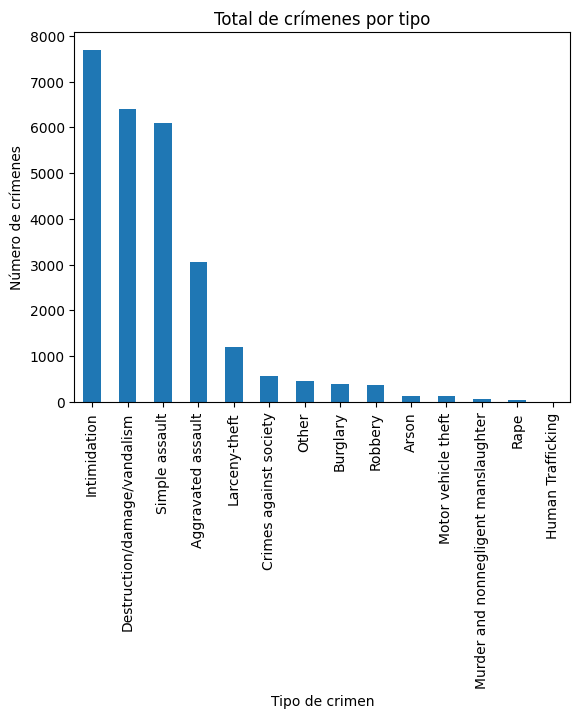

In [43]:
# Calcular la suma total de cada tipo de crimen
total_crimes = df_2.sum(numeric_only=True)

# Ordenar los crímenes de mayor a menor cantidad
total_crimes_sorted = total_crimes.sort_values(ascending=False)

# Convertir la serie ordenada en un DataFrame
result_df = total_crimes_sorted.to_frame(name='Total de Crímenes')

# Mostrar la tabla resultante usando tabulate
print(tabulate(result_df, headers='keys', tablefmt='psql'))

# Gráfico de barras de la suma total de cada tipo de crimen ordenado
total_crimes_sorted.plot(kind='bar')
plt.title('Total de crímenes por tipo')
plt.xlabel('Tipo de crimen')
plt.ylabel('Número de crímenes')
plt.show()

A continuación se presenta un gráfico de barras horizontal, que se ha utilizado para visualizar la distribución de incidentes por localización. Este tipo de gráfico permite comparar de manera clara y ordenada la cantidad de incidentes en diferentes ubicaciones, facilitando la identificación de áreas con mayores niveles de incidencia. Al ordenar las barras de manera descendente según la cantidad de incidentes, se destacan las localizaciones más afectadas.

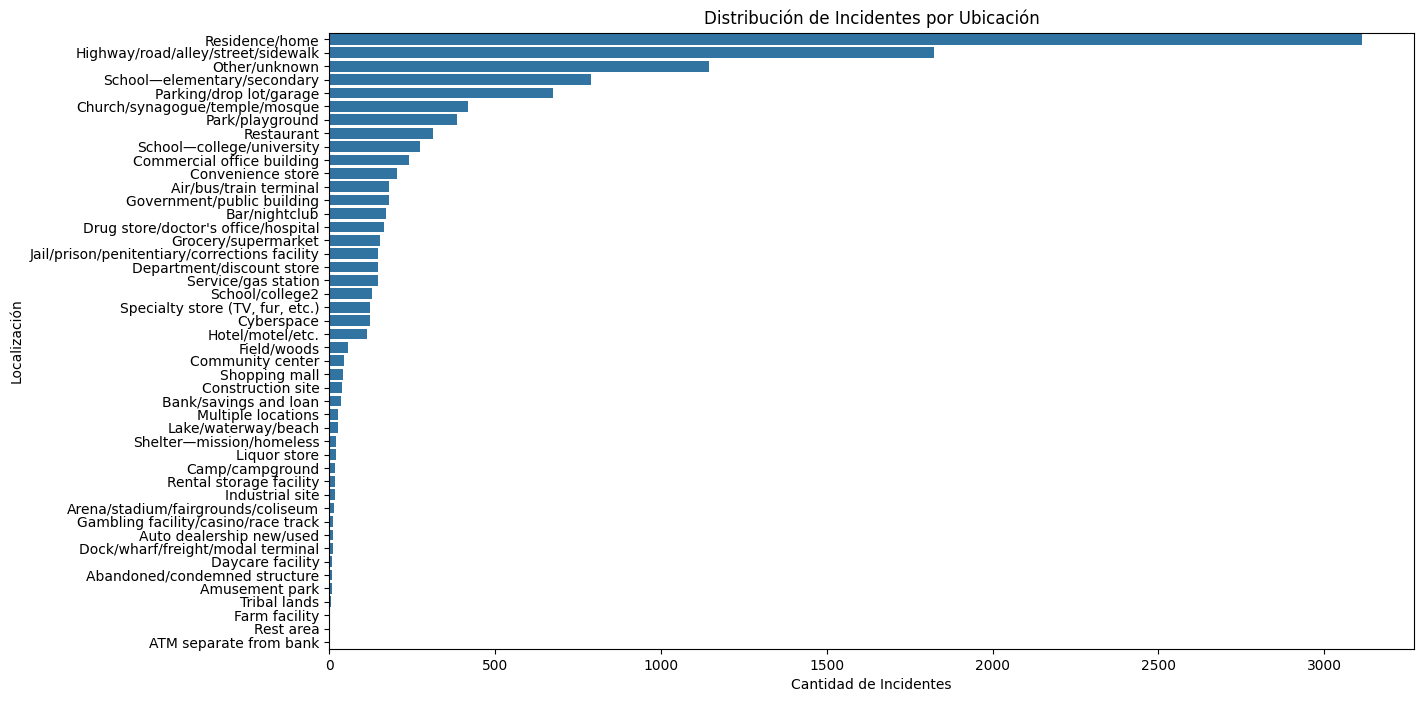

In [44]:
# Crear el gráfico de barras horizontal
plt.figure(figsize=(14, 8))
sns.barplot(data=df, x='Total incidents', y='Location', order=df.sort_values('Total incidents', ascending=False)['Location'])
plt.title('Distribución de Incidentes por Ubicación')
plt.xlabel('Cantidad de Incidentes')
plt.ylabel('Localización')
plt.show()

Vemos que la localización donde más incidentes se producen es en los hogares y residencias, seguido de las calles.

Ahora ya podemos eliminar la columna del total de incidencias que se dieron en cada localización, porque como ya se mencionó anteriormente, esta información no nos interesa para el objetivo del análisis que vamos a realizar.


In [45]:
# Se eliminan las columnas de totales
df = df.drop(columns=df.columns[1])

df.head()

,Location,Race Ethnicity Ancestry,Religion,Sexual orientation,Disability,Gender,Gender Identity
1,Abandoned/condemned structure,6.0,1.0,2.0,0.0,0.0,0.0
2,Air/bus/train terminal,112.0,18.0,29.0,2.0,2.0,8.0
3,Amusement park,6.0,2.0,1.0,0.0,0.0,0.0
4,Arena/stadium/fairgrounds/coliseum,8.0,2.0,3.0,1.0,0.0,0.0
5,ATM separate from bank,2.0,0.0,0.0,0.0,0.0,0.0


El gráfico de treemap se ha utilizado para visualizar la distribución de incidentes según su tipo de motivación. Este tipo de gráfico permite representar de manera clara y proporcional la magnitud de cada tipo de motivación en relación con el total de incidentes. Cada bloque en el treemap representa un tipo de motivación, y su tamaño es directamente proporcional al número de incidentes asociados. Los colores diferenciados ayudan a distinguir visualmente entre los diferentes tipos de motivación. Esta visualización es especialmente útil para identificar rápidamente qué tipos de motivación son más prevalentes.

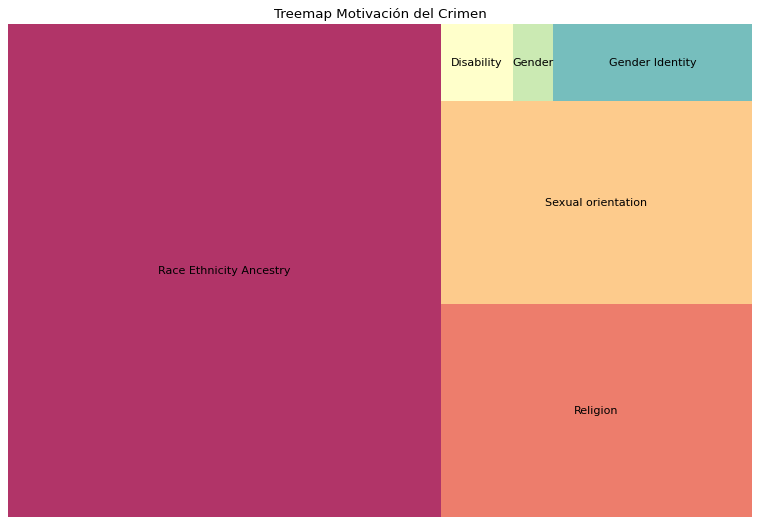

In [46]:
labels = df.columns[1:].tolist()
sizes = df.iloc[:, 1:].sum()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(12,8), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# Decorate
plt.title('Treemap Motivación del Crimen')
plt.axis('off')
plt.show()

El gráfico treemap revela que la motivación más común detrás de los crímenes es la relacionada con la raza, etnia y ascendencia, representando más de la mitad del total de incidentes. Esta predominancia indica que los prejuicios raciales y étnicos son un factor significativo en la comisión de estos crímenes.

El mapa que se presenta a continuación se ha utilizado para visualizar la distribución geográfica de incidentes por estado en los Estados Unidos. Este tipo de gráfico permite mostrar la densidad de incidentes en diferentes estados utilizando una escala de colores, donde los tonos más oscuros indican una mayor cantidad de incidentes. Al emplear datos geojson para los límites de los estados, el mapa proporciona una representación geoespacial precisa y detallada. Esta visualización facilita la identificación de patrones regionales y permite observar claramente cómo varía la cantidad de incidentes entre los distintos estados del país.

In [47]:
# Descargar el archivo geojson de los estados de EE. UU.
url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
response = requests.get(url)
states_geojson = response.json()

# Cargar datos geojson de los estados
with requests.get(url) as response:
    states_geojson = response.json()

total_estado = df_3.iloc[:, 1:].sum(axis=1)
total_estado = pd.to_numeric(total_estado, errors='coerce')

# Crear el mapa de coropletas con
fig = px.choropleth(df_3,
                    geojson=states_geojson,
                    locations=df_3.columns[0],
                    featureidkey="properties.name",
                    color=total_estado,
                    color_continuous_scale="Blues",
                    range_color=(total_estado.min(), total_estado.max()),
                    scope="usa"
                   )

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(width=1000, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Esta visualización muestra que California se destaca significativamente respecto a otros estados, indicando que allí se registra una cantidad mucho mayor de crímenes.

Se utiliza un gráfico de barras divergentes para visualizar la variación de incidentes de intimidación por estado. Este gráfico ordena los estados según el número de incidentes de intimidación y utiliza la puntuación z para estandarizar los valores, destacando las desviaciones por encima y por debajo de la media. Los colores aplicados indican estas desviaciones: los valores por debajo de la media se muestran en verde, mientras que los valores por encima de la media se muestran en rojo. Esta visualización facilita la identificación de estados con incidentes de intimidación significativamente altos o bajos, permitiendo observar claramente cómo varían estos incidentes entre los distintos estados del país.

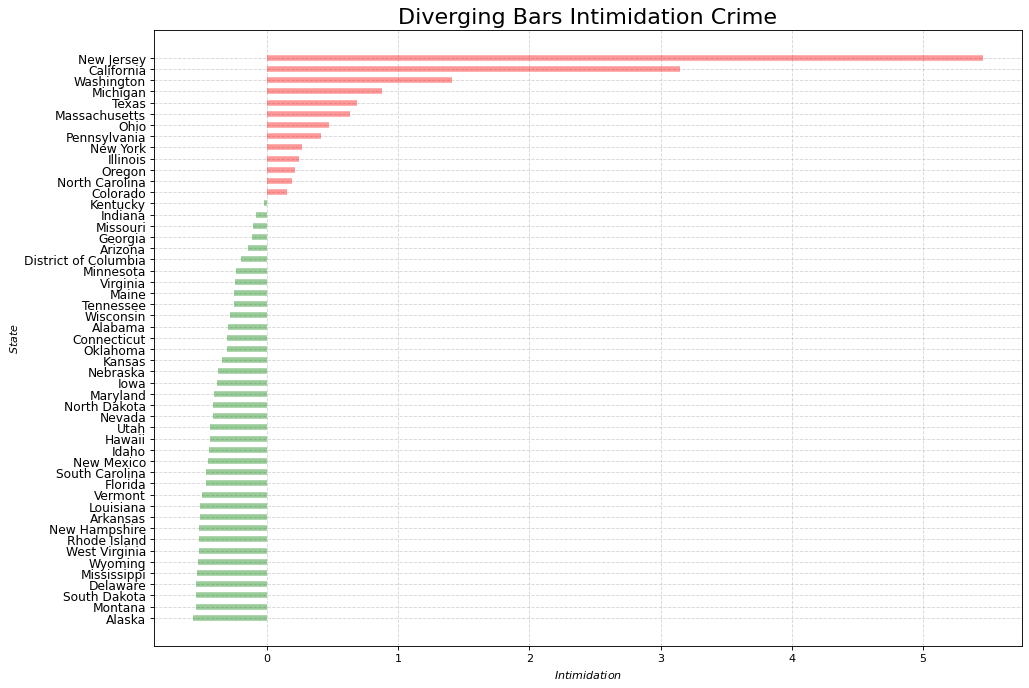

In [48]:
df_3_sorted = df_3.sort_values(by='Intimidation')
# Restablecer los índices del DataFrame ordenado
df_3_sorted.reset_index(drop=True, inplace=True)

intimidation_z = (df_3_sorted['Intimidation'] - df_3_sorted['Intimidation'].mean()) / df_3_sorted['Intimidation'].std()
# Aplicar colores basados en los valores de la puntuación z
colors = ['green' if x < 0 else 'red' for x in intimidation_z]

# Draw plot
plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y=df_3_sorted.index, xmin=0, xmax=intimidation_z, color=colors, alpha=0.4, linewidth=5)

# Decorations
plt.gca().set(ylabel='$State$', xlabel='$Intimidation$')
plt.yticks(df_3_sorted.index, df_3_sorted[df_3_sorted.columns[0]], fontsize=11)
plt.title('Diverging Bars Intimidation Crime', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
plt.show()

# Análisis de delitos por estado:

Se realizará una agrupación por clúster de los distintos crímenes en cada estado. De esta manera, se verá con más claridad en qué estados se dan los mismos crímenes.

In [49]:
print(df_3.head())

  Participating State/Territory/Federal  Murder and nonnegligent manslaughter  \
1                               Alabama                                   1.0   
2                                Alaska                                   0.0   
3                               Arizona                                   0.0   
4                              Arkansas                                   0.0   
5                            California                                   3.0   

   Rape  Aggravated assault  Simple assault  Intimidation  Human Trafficking  \
1   2.0                31.0            66.0          37.0                0.0   
2   0.0                 0.0             0.0           1.0                0.0   
3   0.0                36.0            75.0          58.0                0.0   
4   0.0                 7.0             8.0           8.0                0.0   
5   3.0               435.0           538.0         510.0                0.0   

   Robbery  Burglary  Larceny-th

Se pueden visualizar los datos usando un gráfico de barras apilado donde saldrán los crímenes de cada estado por colores en función del tipo de crimen.

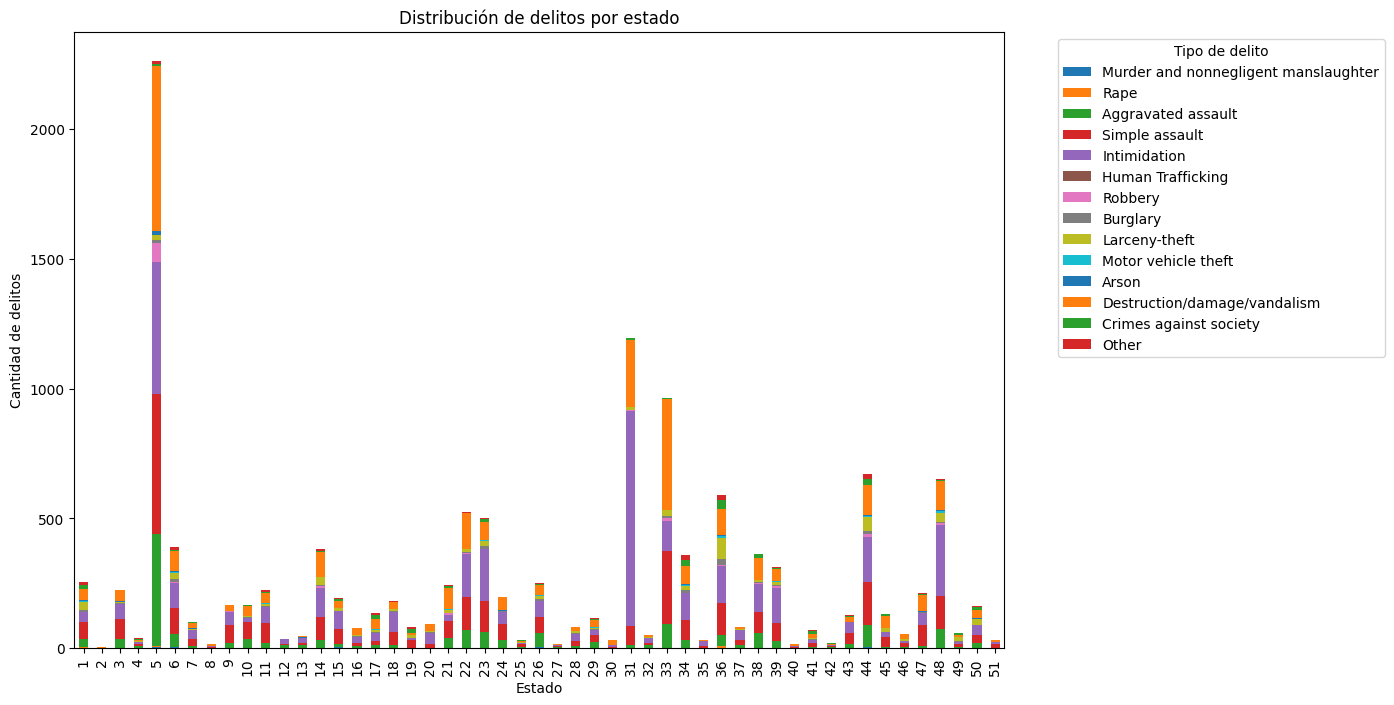

In [50]:
# Crear un gráfico de barras apilado
df_3.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Distribución de delitos por estado')
plt.xlabel('Estado')
plt.ylabel('Cantidad de delitos')
plt.legend(title='Tipo de delito', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Dado que hay datos muy desestandarizados se van a normalizar antes de realizar clúster para evitar que haya sesgos. Primero, se verá la matriz de correlación aunque en este caso interesa estudiar qué crímenes son los más correlacionados entre sí. Por ello, no se eliminarán los registros más correlacionados.

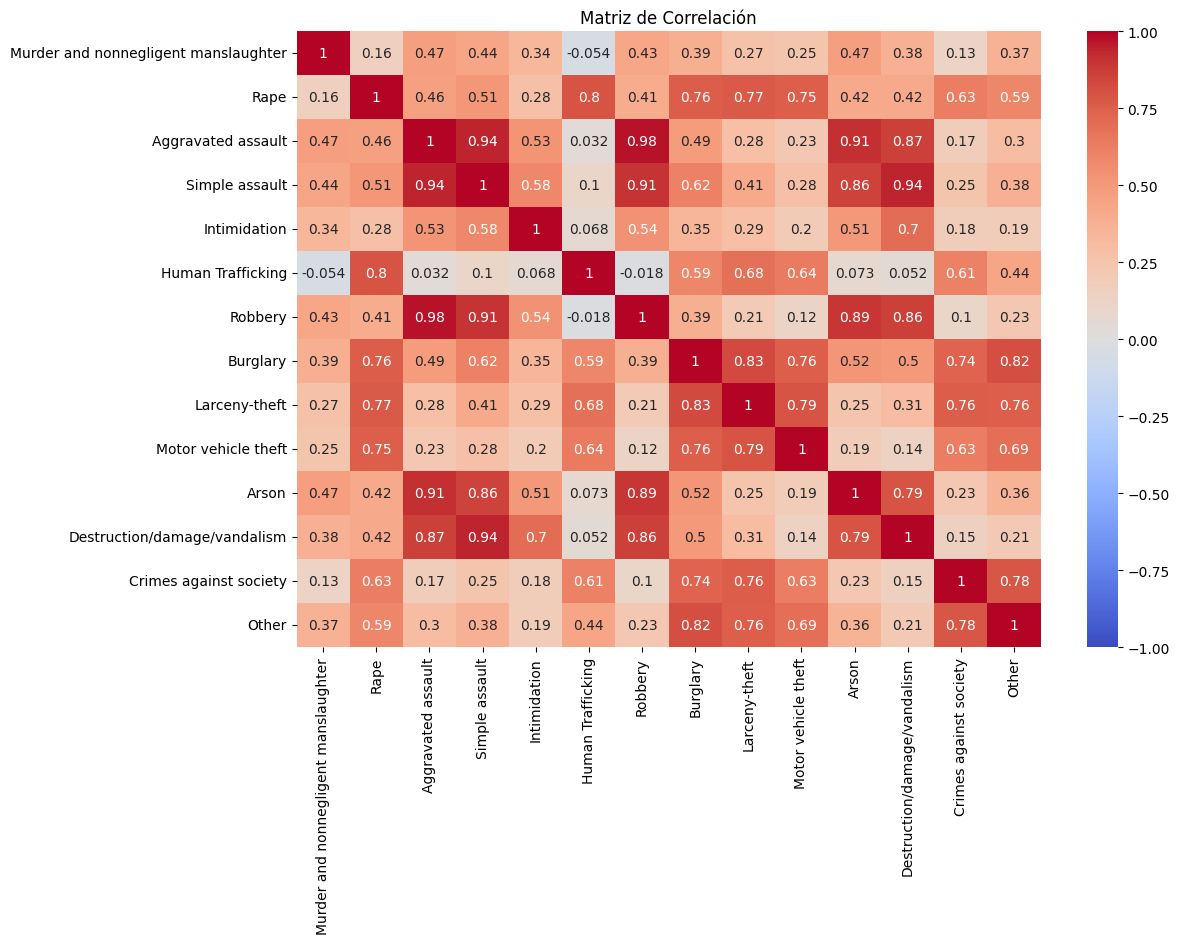

In [51]:

df_clustering = df_3[df_3.columns[1:]]

# Calcular la matriz de correlación
correlation_matrix = df_clustering.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de Correlación")
plt.show()


Se puede ver que los asaltos tienen una fuerte correlación con los asaltos graves, con el vandalismo, con los incendios provocados y con los robos. Por otro lado, las violaciones tienen mucha correlación con el tráfico de personas, lo cual tiene sentido. Pero, curiosamente, también tienen relación con los robos de vehículos. Con los clústers se podrán ver más relaciones entre crímenes distinguiéndolos por estado.

Normalizar los datos:

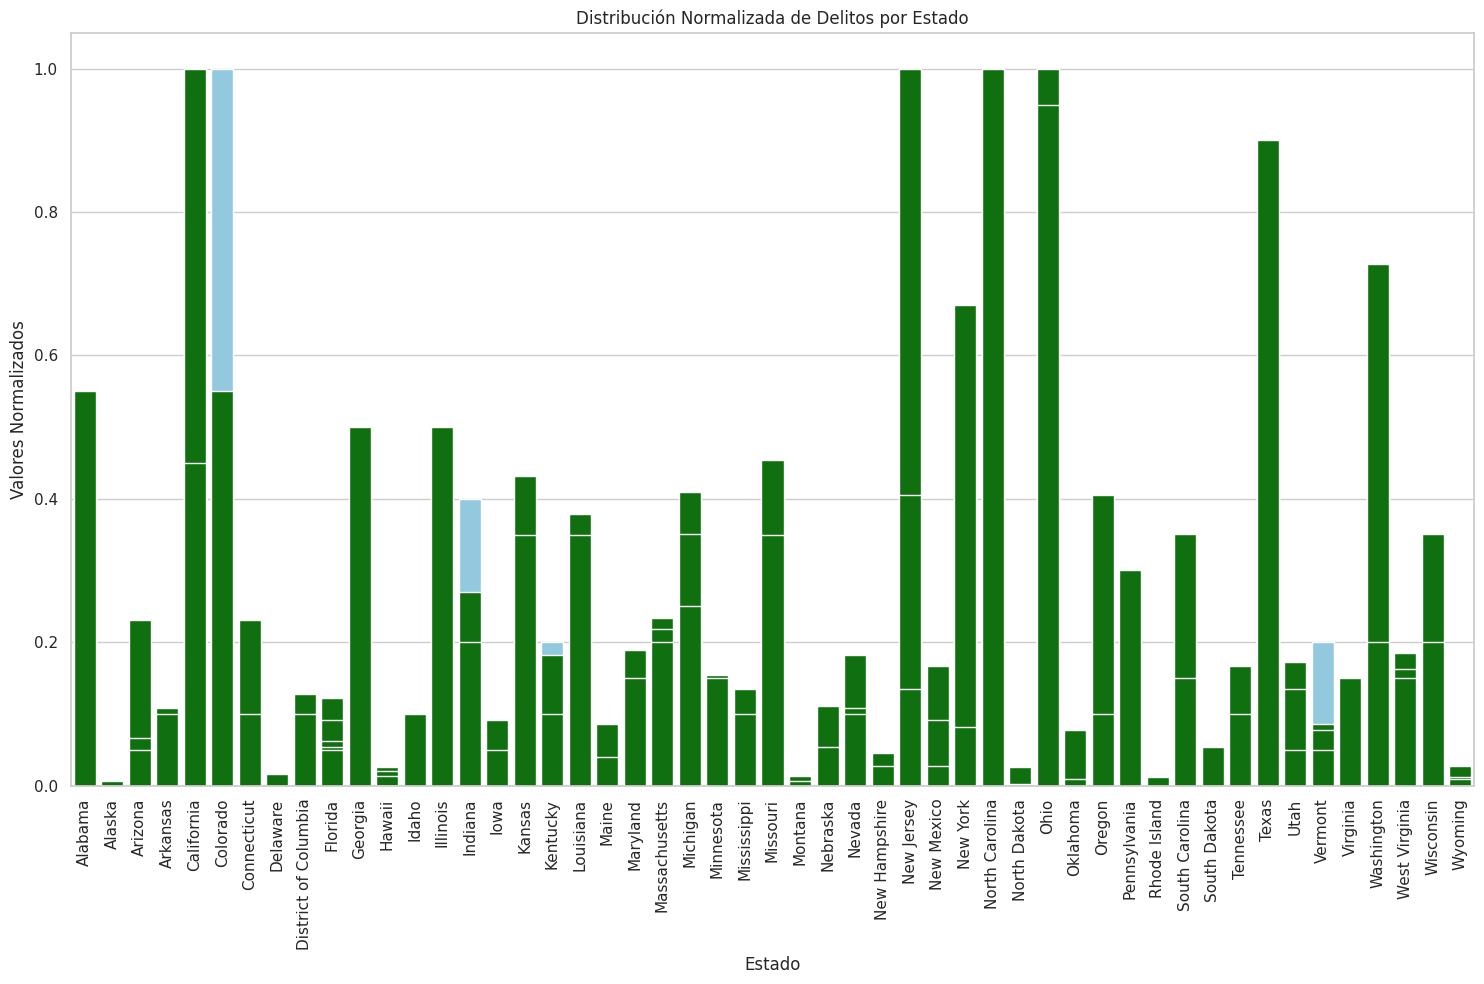

In [52]:
df_clustering = df_3[df_3.columns[1:]]

# Normalizar los datos
scaler = MinMaxScaler()
df_clustering_normalized = scaler.fit_transform(df_clustering)

# Convertir el array normalizado de vuelta a un DataFrame para facilitar la manipulación y visualización
df_clustering_normalized = pd.DataFrame(df_clustering_normalized, columns=df_clustering.columns)

# Agregar una columna con los nombres de los estados para facilitar la visualización
df_clustering_normalized['Estado'] = df_3['Participating State/Territory/Federal'].values

# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Configurar el tamaño del gráfico
plt.figure(figsize=(15, 10))

# Graficar utilizando Seaborn
sns.barplot(data=df_clustering_normalized, x='Estado', y=df_clustering_normalized.columns[0], color='skyblue')
bottom = np.zeros_like(df_clustering_normalized[df_clustering_normalized.columns[0]])
for i in range(1, len(df_clustering.columns)):
    sns.barplot(data=df_clustering_normalized, x='Estado', y=df_clustering_normalized.columns[i], color=colors[i])
    bottom += np.array(df_clustering_normalized[df_clustering_normalized.columns[i - 1]])
plt.xlabel('Estado')
plt.ylabel('Valores Normalizados')
plt.title('Distribución Normalizada de Delitos por Estado')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Los valores ahora son más manejables, no habrá el sesgo que habría con los iniciales.

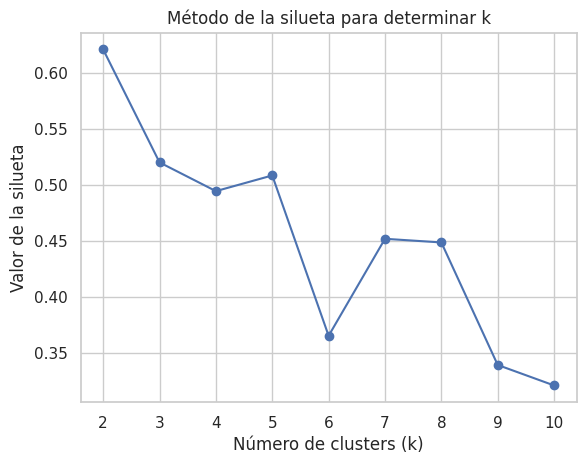

In [53]:
df_clustering_normalized = df_clustering_normalized[df_clustering_normalized.columns[:-1]]

# Lista para almacenar los valores de la silueta
silhouette_scores = []

# Rango de valores de k (número de clusters)
k_range = range(2, 11)  # Puedes ajustar este rango según tus necesidades

# Calcular el valor de la silueta para cada valor de k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_clustering_normalized)
    silhouette_avg = silhouette_score(df_clustering_normalized, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Graficar el método de la silueta
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Valor de la silueta')
plt.title('Método de la silueta para determinar k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

El número óptimo de clústers es 2, de todas formas se pueden hacer más grupos, ya que con k=2 sale un grupo con casi todas las observaciones y otro con uno de los outliers. Esto puede ser debido a que tenemos pocos registros en algunos crímenes y los ubica con los grupos más grandes. Nos interesa, por tanto, tener más clústers para conseguir que se especialice un poco más y separe los delitos menos frecuentes de los demás.

In [54]:
# Crear un modelo de K-Means con el número deseado de clusters
num_clusters = 4  # Puedes ajustar este número según tus necesidades
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Entrenar el modelo con los datos
kmeans.fit(df_clustering_normalized)

# Obtener las etiquetas de cluster para cada estado
cluster_labels = kmeans.labels_

# Calcular el delito predominante en cada grupo
cluster_centroids = kmeans.cluster_centers_
predominant_crimes_indices = np.argmax(cluster_centroids, axis=1)

# Nombres de los delitos
delitos = df_clustering.columns

# Mostrar los resultados
for i, predominant_crime_index in enumerate(predominant_crimes_indices):
    print(f"Grupo {i+1}: El delito más común es '{delitos[predominant_crime_index]}'")



Grupo 1: El delito más común es 'Crimes against society'
Grupo 2: El delito más común es 'Other'
Grupo 3: El delito más común es 'Rape'
Grupo 4: El delito más común es 'Aggravated assault'


En el primer clúster el delito más común son los crímenes contra la sociedad, en el dos son otro tipo de delitos que no se han definido, por lo que pueden entenderse como delitos menores. Por otro lado, en el clúster 3 se encuentran las violaciones como predominantes y en el 4 los asaltos graves. A pesar de ser los crímenes que más ocurren hay que estudiar más a fondo cada clúster para encontrar una relación entre distintos delitos dentro de cada uno.

In [55]:
# Añadir las etiquetas de cluster al DataFrame original
df_clustering_normalized['Cluster'] = cluster_labels

# Descripción general de cada cluster
for cluster in range(num_clusters):
    print(f"Cluster {cluster}:")
    cluster_df = df_clustering_normalized[df_clustering_normalized['Cluster'] == cluster]

    if len(cluster_df) > 1:  # Verificar si el clúster tiene más de un individuo
        display(cluster_df.describe())
    else:
        print("Este clúster tiene solo un individuo:")
        display(cluster_df)
    print("\n")

Cluster 0:


,Murder and nonnegligent manslaughter,Rape,Aggravated assault,Simple assault,Intimidation,Human Trafficking,Robbery,Burglary,Larceny-theft,Motor vehicle theft,Arson,Destruction/damage/vandalism,Crimes against society,Other,Cluster
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.0,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.0
mean,0.025641,0.012821,0.031300,0.060576,0.063668,0.0,0.015670,0.057110,0.068376,0.027972,0.041420,0.050398,0.095634,0.089744,0.0
std,0.081815,0.044992,0.037070,0.056714,0.159872,0.0,0.021653,0.062322,0.066595,0.051737,0.063251,0.073230,0.128701,0.096777,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.006897,0.017658,0.008475,0.0,0.000000,0.000000,0.012346,0.000000,0.000000,0.009404,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.020690,0.033457,0.025424,0.0,0.013889,0.045455,0.049383,0.000000,0.000000,0.029781,0.054054,0.100000,0.0
75%,0.000000,0.000000,0.041379,0.111524,0.051453,0.0,0.020833,0.090909,0.111111,0.045455,0.076923,0.061129,0.135135,0.150000,0.0
max,0.400000,0.166667,0.163218,0.234201,1.000000,0.0,0.083333,0.272727,0.271605,0.181818,0.230769,0.405956,0.432432,0.350000,0.0




Cluster 1:


,Murder and nonnegligent manslaughter,Rape,Aggravated assault,Simple assault,Intimidation,Human Trafficking,Robbery,Burglary,Larceny-theft,Motor vehicle theft,Arson,Destruction/damage/vandalism,Crimes against society,Other,Cluster
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0
mean,0.200000,0.150000,0.119310,0.216729,0.148184,0.0,0.068056,0.390909,0.304938,0.327273,0.115385,0.169906,0.259459,0.480000,1.0
std,0.326599,0.094608,0.057307,0.123984,0.086613,0.0,0.060876,0.145644,0.162231,0.201919,0.083086,0.181964,0.209815,0.304777,0.0
min,0.000000,0.000000,0.045977,0.111524,0.043584,0.0,0.013889,0.181818,0.086420,0.000000,0.000000,0.054859,0.081081,0.000000,1.0
25%,0.000000,0.166667,0.067816,0.140335,0.085956,0.0,0.017361,0.272727,0.203704,0.272727,0.076923,0.078762,0.108108,0.275000,1.0
50%,0.000000,0.166667,0.120690,0.175651,0.129540,0.0,0.041667,0.431818,0.277778,0.318182,0.115385,0.114420,0.135135,0.500000,1.0
75%,0.350000,0.166667,0.156322,0.236524,0.189770,0.0,0.104167,0.454545,0.358025,0.431818,0.153846,0.170063,0.391892,0.550000,1.0
max,1.000000,0.333333,0.206897,0.524164,0.328087,0.0,0.166667,0.590909,0.666667,0.727273,0.230769,0.670846,0.621622,1.000000,1.0




Cluster 2:
Este clúster tiene solo un individuo:


,Murder and nonnegligent manslaughter,Rape,Aggravated assault,Simple assault,Intimidation,Human Trafficking,Robbery,Burglary,Larceny-theft,Motor vehicle theft,Arson,Destruction/damage/vandalism,Crimes against society,Other,Cluster
35,0.0,1.0,0.101149,0.228625,0.171913,1.0,0.027778,1.0,1.0,1.0,0.153846,0.15674,1.0,0.95,2




Cluster 3:
Este clúster tiene solo un individuo:


,Murder and nonnegligent manslaughter,Rape,Aggravated assault,Simple assault,Intimidation,Human Trafficking,Robbery,Burglary,Larceny-theft,Motor vehicle theft,Arson,Destruction/damage/vandalism,Crimes against society,Other,Cluster
4,0.6,0.5,1.0,1.0,0.616223,0.0,1.0,0.545455,0.222222,0.181818,1.0,1.0,0.216216,0.45,3


Se puede ver que en los clústers 2 y 3 hay solo una observación, lo que indica que esos delitos están más aislados que los demás. Ahora se verá en qué estado se dan estos delitos con mayor frecuencia y los delitos que contiene cada clúster. Posteriormente, se podrá contrastar esta información con las otras bases de datos para ver contra qué personas se suelen dar comunmente estos delitos.

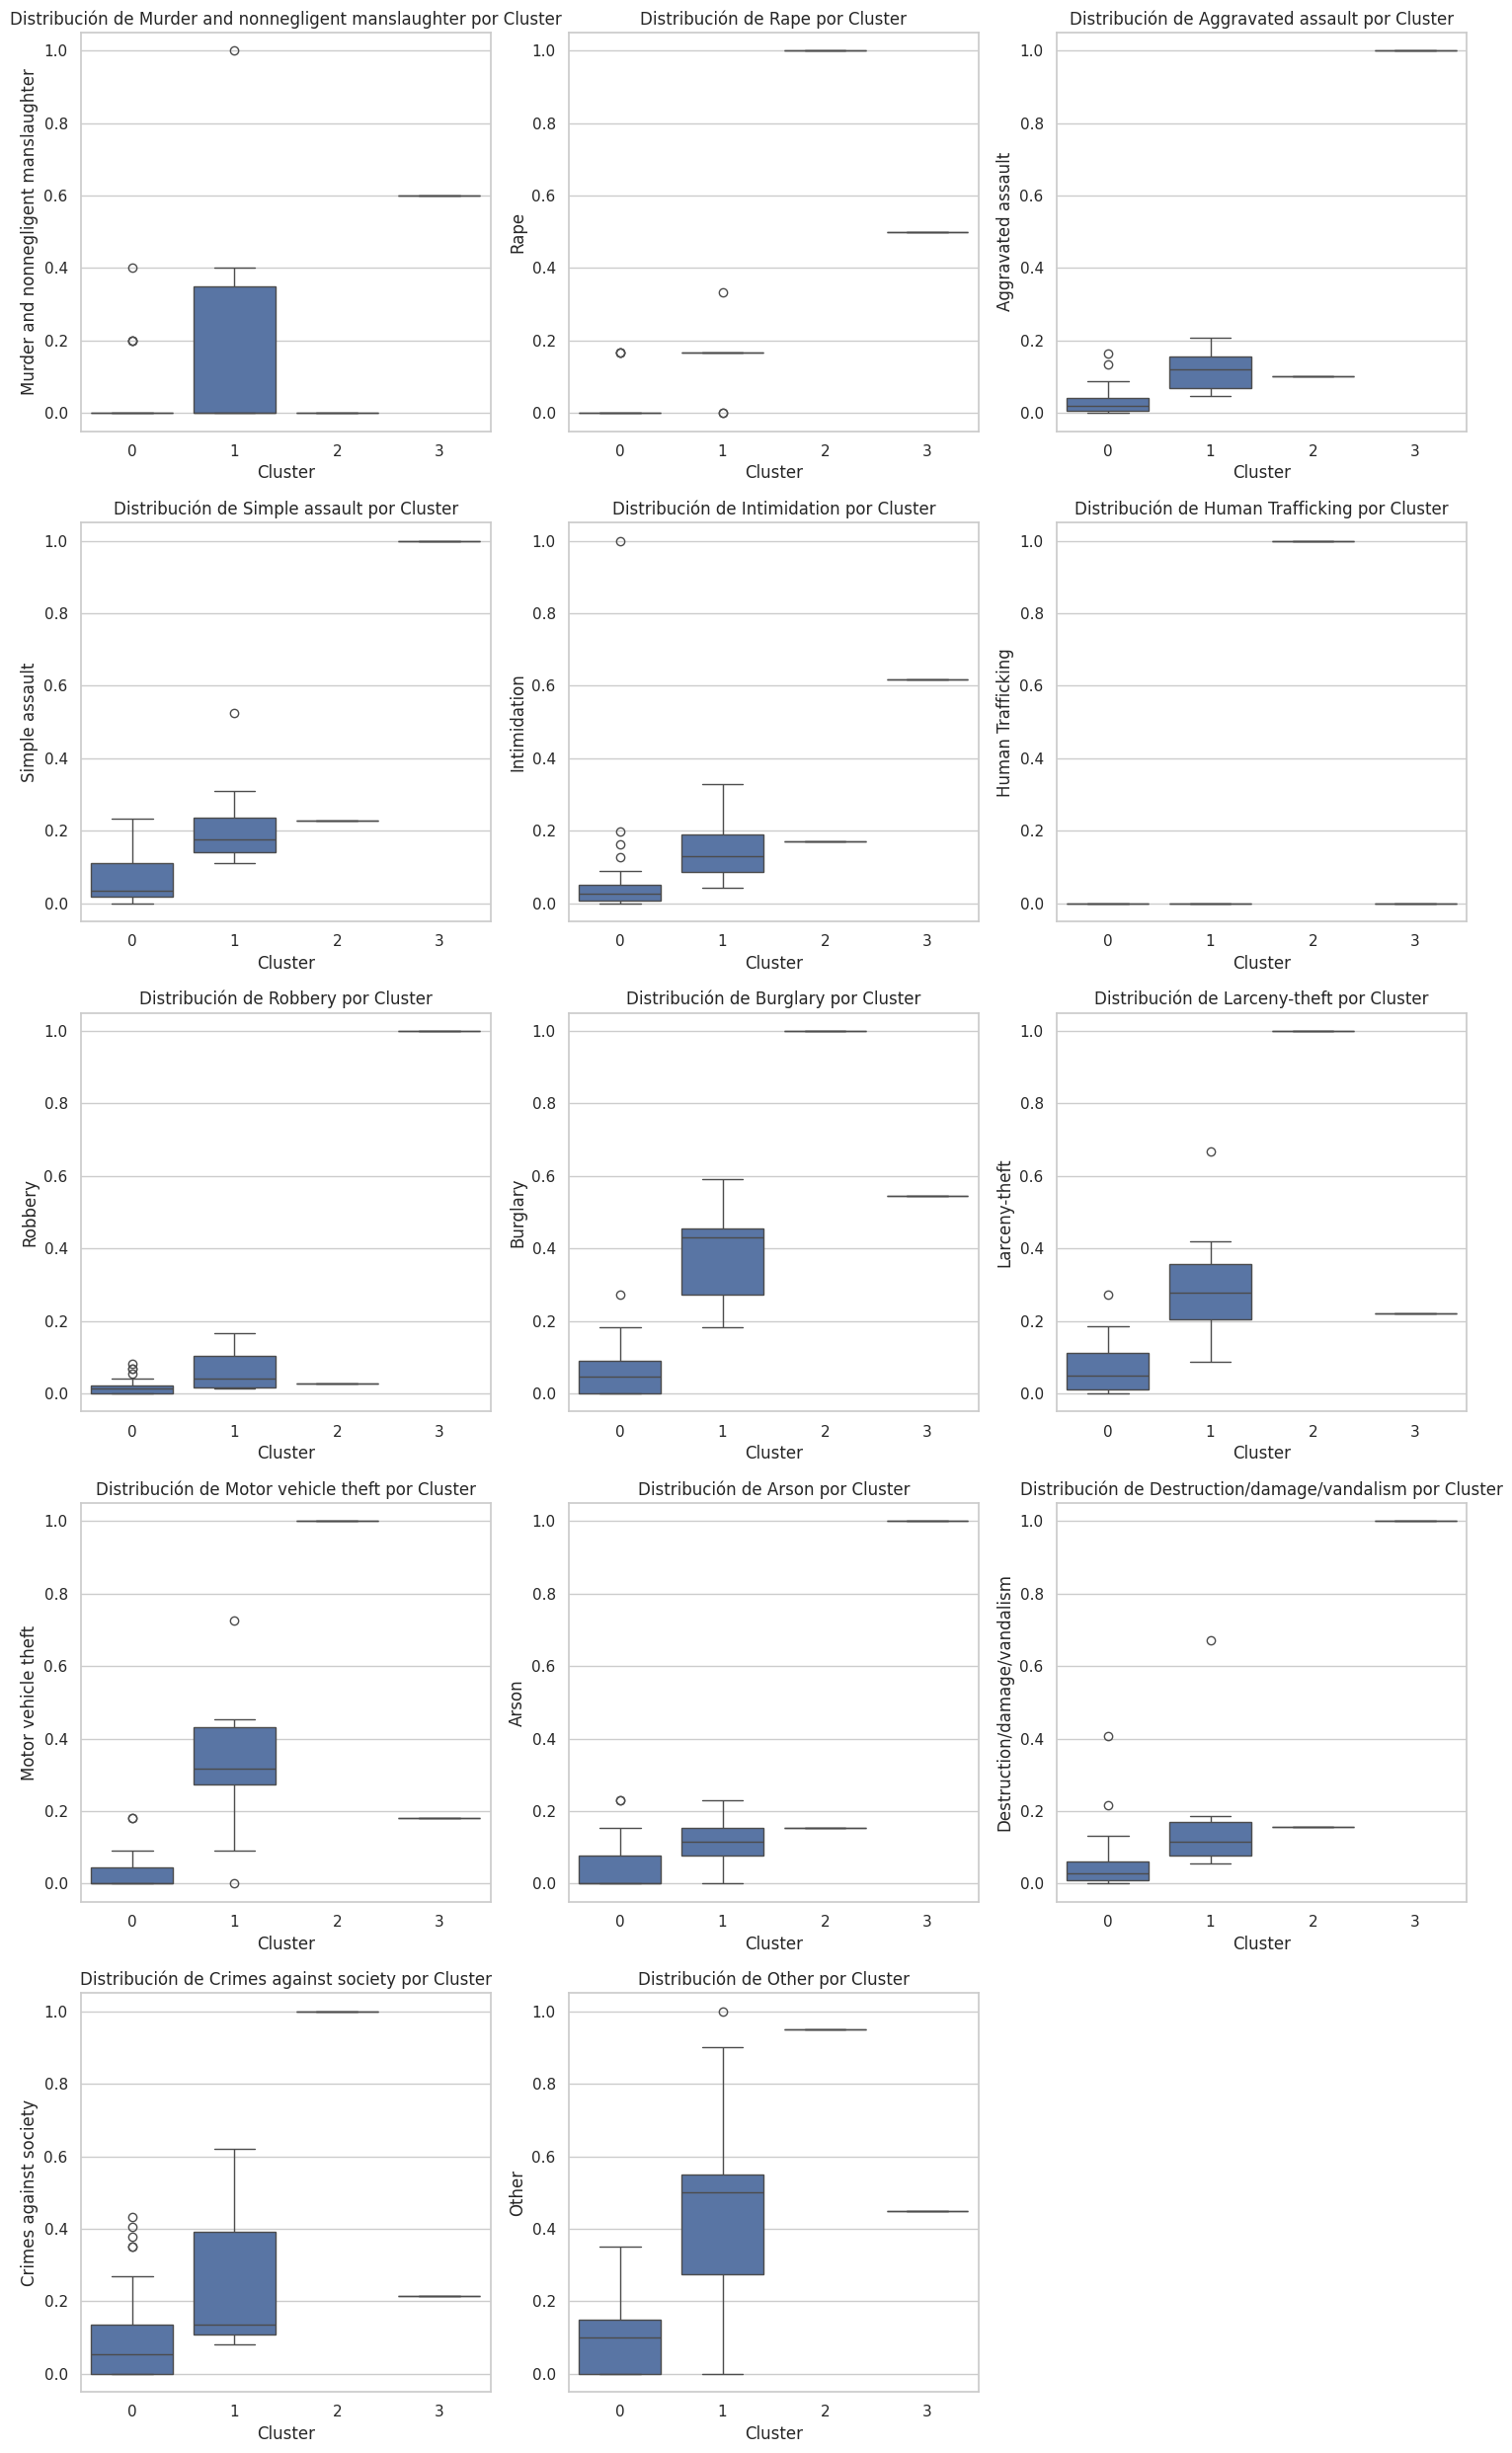

In [56]:
# Número de columnas a graficar
num_crimes = len(df_clustering_normalized.columns) - 1  # Excluir la columna 'Cluster'

# Configurar el tamaño de la figura y la cuadrícula de subplots
rows = (num_crimes // 3) + 1
fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(15, rows * 5))
axes = axes.flatten()

# Crear gráficos de caja para cada tipo de delito por cluster
for i, crime in enumerate(df_clustering_normalized.columns[:-1]):  # Excluir la columna 'Cluster'
    sns.boxplot(x='Cluster', y=crime, data=df_clustering_normalized, ax=axes[i])
    axes[i].set_title(f'Distribución de {crime} por Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(crime)

# Eliminar subplots vacíos si hay menos gráficos que espacios en la cuadrícula
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()


Se puede ver que en el clúster 0 y en el 1 hay claramente muchos crímenes agrupados. Dado que el método de la silueta sugería un k = 2, es entendible que casi todos los registros estén entre dos grupos mayoritarios. De todas formas, los clústers 2 y 3 separan los crímenes que menos se dan de los anteriores.

Se puede ver que en el clúster 2 tienen el valor más alto de tráfico de personas, de violaciones, de delitos contra la sociedad y de robo de vehículos. Concluimos en que estos delitos están relacionados, es decir si se da uno de ellos probablemente se dará otro, esto es interesante para el estudio, pero en esta parte lo que realmente interesa saber es en qué estado ocurren estos crímenes, es decir qué relación tienen con el estado en el que se producen.

Por otro lado, en el clúster 3 están los valores más altos de vandalismo y de asaltos, tanto graves como simples.

En el clúster 0, donde hay más observaciones, se encuentran outliers en asesinatos, algún valor en vandalismo también como outlier y de distintos tipos de robos. Los valores en este clúster están más distribuidos que en los anteriores.

En cuanto al clúster 1, tiene el valor más alto de asesinatos, aunque sea un outlier, es el más alto. También se dan otro tipo de delitos con gran frecuencia, recogidos en la variable 'Other', hay también distintos tipos de robo y entre ellos es alto el de robo de vehículos. Esto puede tener algún tipo de relación con el clúster 2, cuando se vea a qué clúster pertenece cada estado podría ser que el estado del clúster 2 esté cerca de alguno del clúster 1.

Cálculo de la matriz de correlación para ver qué delitos tienden a ocurrir juntos:

En este paso, se mostrarán solo las matrices de correlación de los clústers 0 y 1, ya que los otros dos cuentan con pocas observaciones y no saldrá una matriz interesante para estudiar. Dado que la variable Human trafficking no está en ninguno de estos clústers tampoco se representará. Esto se ve en los diagramas de bigotes, donde los valores para esta variable en los clústers 0 y 1 son igual a cero.

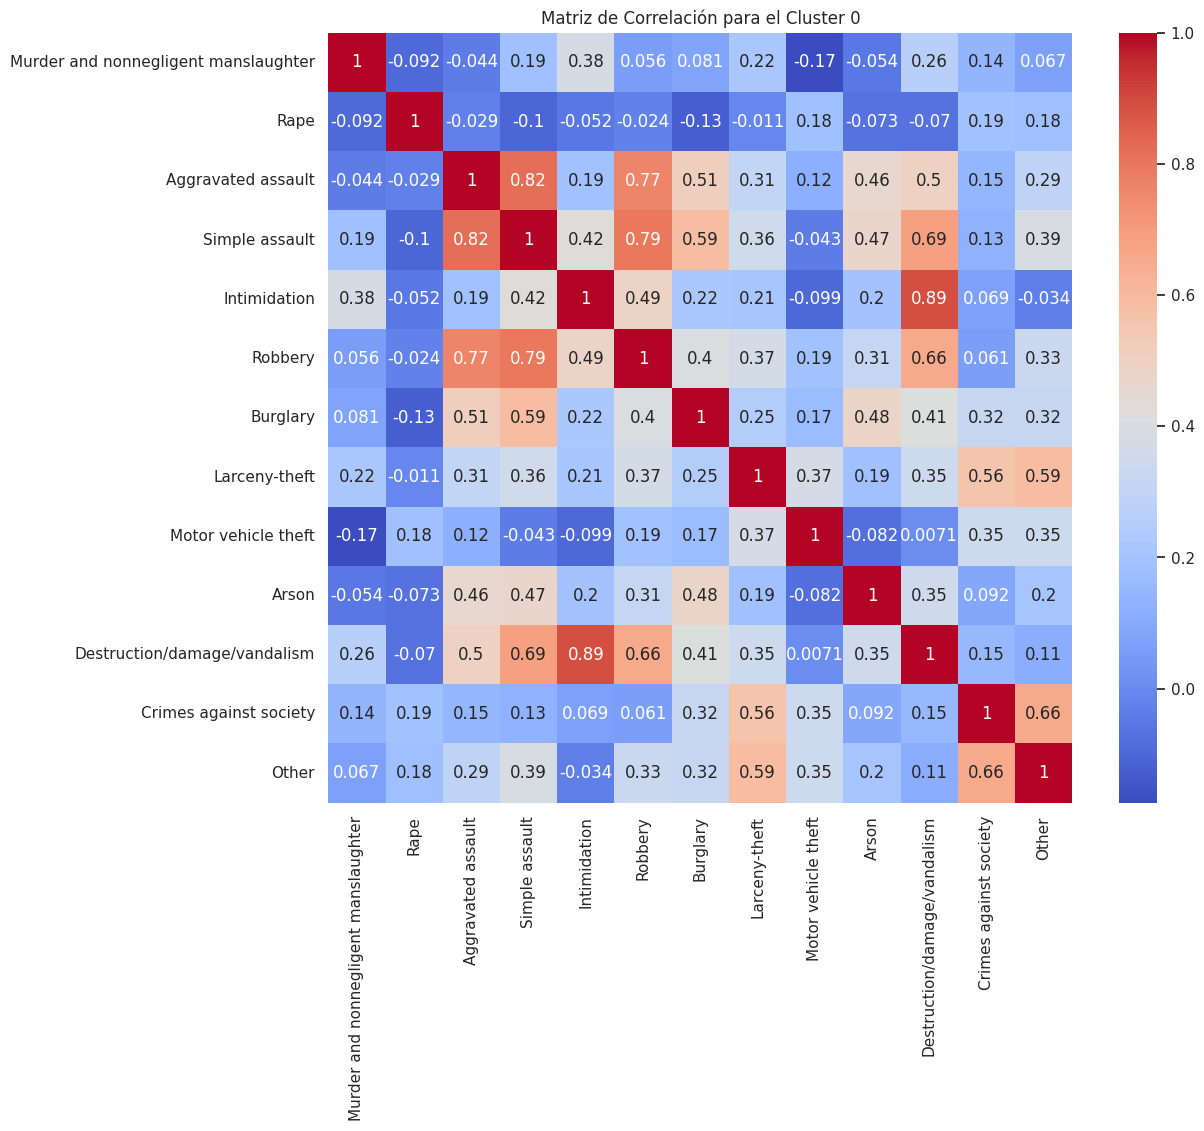

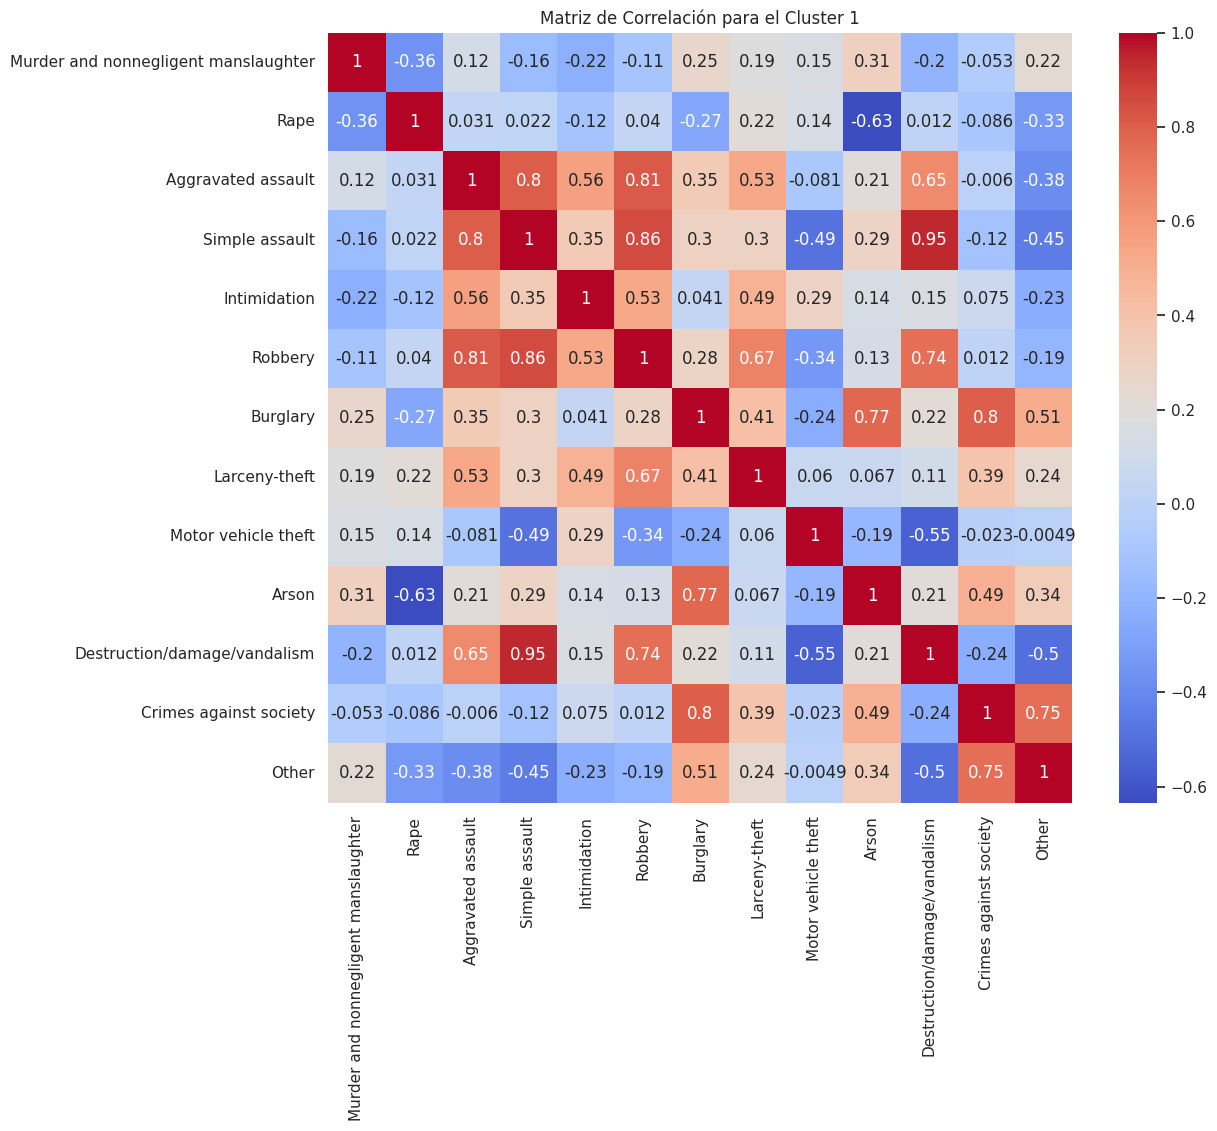

In [57]:
# Calcular la matriz de correlación para cada cluster excluyendo 'Human trafficking'
for cluster in range(2):
    cluster_data = df_clustering_normalized[df_clustering_normalized['Cluster'] == cluster]
    cluster_data = cluster_data.drop(columns=['Cluster', 'Human Trafficking'])
    plt.figure(figsize=(12, 10))
    sns.heatmap(cluster_data.corr(), annot=True, cmap='coolwarm')
    plt.title(f'Matriz de Correlación para el Cluster {cluster}')
    plt.show()

En la matriz del clúster 0 se puede ver que los robos están relacionados con los asaltos y con el vandalismo, por otro lado el vandalismo también se suele dar con la intimidación. En este clúster no hay ninguna correlación negativa muy alta, por lo que no se puede decir que si ocurre un crimen, en general no ocurrirá otro.

En cuanto a la matriz del clúster 1, el vandalismo está mucho más relacionado con los asaltos, por lo que se entiende que, en los estados que pertenezcan a este clúster tienen más probabilidad de que se den estos dos crímenes juntos que en el anterior. Es interesante comentar que, el incendio provocado está inversamente relacionado con las violaciones, se entiende que este tipo de delitos no se suelen dar a la vez en los estados del clúster 1. Por otro lado, el robo de vehículos tiene una relación, también inversa, con el vandalismo, lo que indica que tampoco se suelen dar a la vez en un mismo estado.

Aun así es necesario conocer a qué cluster pertenece cada estado para estudiar más en profundidad donde se dan más los delitos estudiados y cuándo se dan juntos en un mismo estado.

A qué clúster pertenece cada estado:

In [58]:
# Añadir las etiquetas de cluster al DataFrame original
df_3['Cluster'] = cluster_labels

# Mostrar a qué cluster pertenece cada estado
print(df_3[['Participating State/Territory/Federal', 'Cluster']])


   Participating State/Territory/Federal  Cluster
1                                Alabama        1
2                                 Alaska        0
3                                Arizona        0
4                               Arkansas        0
5                             California        3
6                               Colorado        1
7                            Connecticut        0
8                               Delaware        0
9                   District of Columbia        0
10                               Florida        0
11                               Georgia        1
12                                Hawaii        0
13                                 Idaho        0
14                              Illinois        1
15                               Indiana        0
16                                  Iowa        0
17                                Kansas        0
18                              Kentucky        0
19                             Louisiana        0


Se puede ver que en los clústers 0 y 1, donde estaban la mayoría de crímenes también estan casi todos los estados. En el 3 está california, donde hay más delitos. En este estado se da por tanto el vandalismo y los robos con alta frecuencia. En cuanto al clúster 2 está Ohio, en este clúster están los delitos más graves, que son el tráfico de personas y las violaciones. Este además, contiene algunos robos, por lo que se puede entender que es un estado donde se cometen varios crímenes. El resto de estados pertenecen al clúster 3 o al 0.

In [59]:
url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
response = requests.get(url)
states_geojson = response.json()

# Asegúrate de que el índice del DataFrame sea el nombre de los estados
df_clustering.index = df_3['Participating State/Territory/Federal']

# Añadir las etiquetas de cluster al DataFrame original
df_clustering['Cluster'] = cluster_labels

# Crear un DataFrame con los estados y sus clusters
df_clusters = pd.DataFrame({'state': df_clustering.index, 'Cluster': cluster_labels})
# Definimos los valores del Cluster como categóricos
df_clusters['Cluster'] = df_clusters['Cluster'].astype('category')
custom_colors = ['#ffd166', '#118ab2', '#06d6a0', '#ef476f']

# Cargar datos geojson de los estados
with requests.get(url) as response:
    states_geojson = response.json()

# Crear el mapa de coropletas coloreando por cluster
fig = px.choropleth(df_clusters,
                    geojson=states_geojson,
                    locations='state',
                    featureidkey="properties.name",
                    color='Cluster',
                    color_discrete_sequence=custom_colors,  # Set de colores
                    scope="usa",
                    labels={'Cluster':'Cluster'}
                   )

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(width=1000, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Se puede ver que el clúster 3, al que pertence california, está rodeado del clúster 0. En ambos destacaba el vandalismo, por lo que se puede concluir en que en esa zona de Estados Unidos hay bastante vandalismo y por tanto otros delitos relacionados con este comentados antes.

Predomina el clúster 0, que es en el cual están los valores más altos de 'Other', por lo que al ser el clúster más grande tiene sentido que haya crímenes de está variable. Pero, recordando las conclusiones anteriores, este clúster contiene altos valores de asesinato y vandalismo, por lo que se puede entender que este tipo de crímenes se dan en todo el país prácticamente, que no son casos aislados.

En el caso del clúster 2, sí se puede considerar un caso aislado, ya que está rodeado del clúster mayoritario, pero en este si se encuentran otro tipo de delitos más graves como el tráfico de personas y las violaciones.

Es decir, en general, se dan crímenes 'Other' que se podrían entender como crímenes menores, ya que los graves están definidos cada uno en una variable y se ha encontrado un estado centro de delitos más graves, Ohio y otro donde ocurren más delitos relacionados con el robo, el vandalismo, etc. Este último es California, aunque se puede ver en el siguiente gráfico que es el estado en el que más delitos ocurren en general.

In [60]:

# Descargar el archivo geojson de los estados de EE. UU.
url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
response = requests.get(url)
states_geojson = response.json()

# Asegúrate de que el índice del DataFrame sea el nombre de los estados
df_clustering.index = df_3['Participating State/Territory/Federal']

# Añadir las etiquetas de cluster al DataFrame original
df_clustering['Cluster'] = cluster_labels

# Calcular la suma de crímenes por estado
crime_totals = df_clustering.drop('Cluster', axis=1).sum(axis=1)

# Crear un DataFrame con los estados y la suma de crímenes
df_crime_totals = pd.DataFrame({'state': df_clustering.index, 'Total Crimes': crime_totals})
df_crime_totals['Total Crimes'] = pd.to_numeric(df_crime_totals['Total Crimes'], errors='coerce')

# Cargar datos geojson de los estados
with requests.get(url) as response:
    states_geojson = response.json()

# Crear el mapa de coropletas con
fig = px.choropleth(df_crime_totals,
                    geojson=states_geojson,
                    locations='state',
                    featureidkey="properties.name",
                    color='Total Crimes',
                    color_continuous_scale="Blues",
                    scope="usa",
                    labels={'Total Crimes':'Total de Crímenes'}
                   )

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(width=1000, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Análisis Motivación - Crimen

Para ver patrones que puedan ser de utilidad en esta base de datos aplicaremos la técnica de Clustering con el algoritmo k-means. El objetivo es identificar qué motivaciones están ligadas a qué crimenes y en qué grado.

Para ver el número óptimo de clusters que debemos usar realizamos el método del codo.

El método del codo es una técnica utilizada para determinar el número óptimo de clusters en un algoritmo de agrupamiento, como K-means. Consiste en calcular la variabilidad intra-cluster (también conocida como la suma de los cuadrados de las distancias dentro del cluster) para diferentes valores de k (número de clusters) y graficar estos valores en función de k.


El nombre "método del codo" proviene de la forma del gráfico resultante, que a menudo se asemeja a un codo. La idea es identificar el punto en el gráfico donde la disminución en la variabilidad intra-cluster comienza a desacelerarse significativamente. Este punto se considera una indicación del número óptimo de clusters, ya que representa el punto donde agregar más clusters ya no proporciona una mejora sustancial en la variabilidad dentro de los clusters.


En el algoritmo K-means, el método del codo se usa para ayudar a seleccionar el número óptimo de clusters, lo que a su vez ayuda a definir la estructura de agrupamiento de los datos. Al determinar el número correcto de clusters, se puede lograr un equilibrio entre la densidad de los clusters individuales y la separación entre ellos, lo que lleva a una mejor interpretación y comprensión de los patrones presentes en los datos.


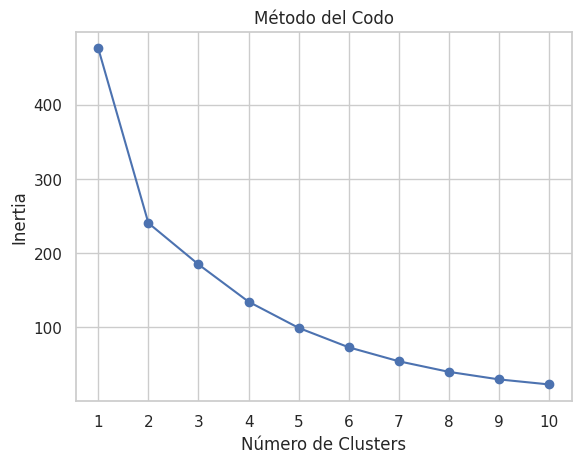

In [61]:
# Supongamos que tienes un DataFrame llamado df y una lista de variables que quieres incluir en el clustering
variables_a_incluir = ['Murder and nonnegligent manslaughter', 'Rape',
                       'Aggravated assault', 'Simple assault', 'Intimidation',
                       'Human Trafficking', 'Robbery', 'Burglary', 'Larceny-theft',
                       'Motor vehicle theft', 'Arson', 'Destruction/damage/vandalism',
                       'Crimes against society', 'Other']

# Seleccionar las variables deseadas del DataFrame
features = df_2_esp[variables_a_incluir]

# Normalizar las características
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Lista para almacenar las sumas de los cuadrados de las distancias
inertia_values = []

# Rango de número de clusters que deseas probar
k_values = range(1, 11)

# Aplicar KMeans para cada número de clusters y calcular la suma de los cuadrados de las distancias
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_normalized)
    inertia_values.append(kmeans.inertia_)

# Graficar el método del codo
plt.plot(k_values, inertia_values, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()

En nuestro caso vemos un codo claro en el valor k=2, sin embargo, para poder crear grupos más específicos, tras varias pruebas hemos decidido quedarnos con k=4. Este k elegido nos ha ayudado a conseguir grupos un poco más generales que aporten una mayor información.

In [62]:
# Definir el número de clusters (puedes editar este valor)
num_clusters = 4

# Aplicar KMeans con el número de clusters especificado
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(features_normalized)

# Agregar la columna con el número del cluster al DataFrame features
features['Cluster'] = kmeans.labels_

# Calcular y mostrar la cantidad de observaciones en cada cluster
cluster_counts = features['Cluster'].value_counts()
print(cluster_counts)

Cluster
3    24
0     8
1     1
2     1
Name: count, dtype: int64


Vemos que quedan dos clusters con una observación cada uno, otro con 8 observaciones y un úlitmo de 24.

In [63]:
# Crear un DataFrame solo con la columna 'Cluster' del DataFrame features
cluster_column = features[['Cluster']]

# Asegurarse de que ambos DataFrames tienen el mismo índice
df_2 = df_2_esp.reset_index(drop=True)
cluster_column = cluster_column.reset_index(drop=True)

# Combinar df_2 con la columna 'Cluster'
df_combined = pd.concat([df_2, cluster_column], axis=1)

# Mostrar el DataFrame combinado
df_combined.head()

,Bias motivation,Murder and nonnegligent manslaughter,Rape,Aggravated assault,Simple assault,Intimidation,Human Trafficking,Robbery,Burglary,Larceny-theft,Motor vehicle theft,Arson,Destruction/damage/vandalism,Crimes against society,Other,Cluster
0,Anti-White,1.0,3.0,155.0,323.0,259.0,0.0,34.0,22.0,99.0,18.0,7.0,123.0,42.0,40.0,1
1,Anti-Black or African American,13.0,4.0,501.0,875.0,1482.0,0.0,33.0,32.0,70.0,14.0,12.0,948.0,68.0,23.0,2
2,Anti-American Indian or Alaska Native,0.0,0.0,21.0,31.0,20.0,0.0,1.0,9.0,45.0,9.0,1.0,29.0,31.0,20.0,0
3,Anti-Asian,0.0,0.0,79.0,190.0,191.0,1.0,20.0,13.0,17.0,0.0,1.0,84.0,5.0,1.0,0
4,Anti-Native Hawaiian or Other Pacific Islander,0.0,0.0,5.0,5.0,5.0,0.0,0.0,4.0,2.0,0.0,0.0,2.0,4.0,3.0,3


In [64]:
# Suponiendo que la primera columna es 'Bias Motivation' y la última es 'Cluster'
first_col = 'Bias motivation'
last_col = 'Cluster'

# Agrupar por 'Cluster' y sumar las columnas (exceptuando la primera y la última)
sum_table = df_combined.drop(columns=[first_col, last_col]).groupby(df_combined[last_col]).sum()

# Crear un diccionario para almacenar las listas de elementos de la primera variable por cada cluster
bias_motivation_lists = df_combined.groupby('Cluster')[first_col].apply(list)

# Mostrar los resultados por cada cluster
for cluster in sum_table.index:
    print(f"Cluster {cluster}")
    print("Suma de valores por variable:")
    print(sum_table.loc[cluster])
    print("Lista de elementos de la primera variable:")
    for item in bias_motivation_lists[cluster]:
        print(item)
    print("\n")

Cluster 0
Suma de valores por variable:
Murder and nonnegligent manslaughter      12.0
Rape                                       6.0
Aggravated assault                       659.0
Simple assault                          1350.0
Intimidation                            1478.0
Human Trafficking                          2.0
Robbery                                  105.0
Burglary                                  69.0
Larceny-theft                            274.0
Motor vehicle theft                       22.0
Arson                                     19.0
Destruction/damage/vandalism            1415.0
Crimes against society                    83.0
Other                                     93.0
Name: 0, dtype: float64
Lista de elementos de la primera variable:
Anti-American Indian or Alaska Native
Anti-Asian
Anti-Hispanic or Latino
Anti-Jewish
Anti-Sikh
Anti-Gay (Male)
Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group)
Anti-Transgender


Cluster 1
Suma de valores por variable:
Murder 

Para ver la información de cada cluster vemos por un lado las motivaciones que están implicadas en cada uno, y la suma total de cada delito.

**Cluster 0:** El Cluster 0 muestra un patrón de crímenes con una amplia gama de tipos delictivos, con una marcada incidencia en crímenes como "Simple assault" e "Intimidation", siendo este último el más común con 1478 incidentes. Además, se registran altos números en "Destruction/ damage/ vandalism" con 1415 casos y "Aggravated assault" con 659 casos. Dentro de los crímenes menos frecuentes, pero aún significativos se encuentran "Robbery" con 105 casos y "Larceny-theft" con 274 casos. También cabe destacar, que en este cluster se encuentran todos los delitos de tráfico humano que hay en la base de datos. La motivación de estos crímenes apunta hacia una amplia variedad de grupos, como personas de ascendencia americana indígena o nativa de Alaska, asiáticas, hispanas o latinas, judías, sijes, hombres gays, lesbianas, bisexuales o transexuales, y personas transgénero. Esta diversidad en las motivaciones sugiere un entorno social complejo con tensiones y prejuicios dirigidos hacia múltiples identidades étnicas y de género. Es notable que la incidencia de crímenes contra la sociedad es relativamente alta, con 83 casos, lo que sugiere una preocupación por la violencia que afecta a la comunidad en su conjunto.

**Cluster 1:** El Cluster 1 presenta una distribución de crímenes con un énfasis particular en aquellos relacionados con la intimidación, el asalto simple y el asalto agravado, con 259, 323 y 155 casos respectivamente. Si bien los crímenes violentos como el asesinato y la violación también están presentes, su incidencia es relativamente baja en comparación con otros tipos de crímenes. La motivación principal para estos crímenes parece ser el prejuicio hacia individuos blancos, como lo indica la lista de elementos de la primera variable, que incluye motivaciones como "Anti-White". Esta concentración en crímenes dirigidos específicamente hacia individuos blancos sugiere tensiones raciales significativas y posiblemente un clima social donde el racismo desempeña un papel importante en la comisión de delitos. Es importante destacar que, en comparación con otros clusters, la cantidad total de crímenes en este cluster es relativamente baja, lo que podría indicar una concentración de este tipo específico de delitos en áreas o contextos particulares.

**Cluster 2:** El Cluster 2 muestra una alta incidencia de diversos tipos de crímenes, con un énfasis significativo en la intimidación, el asalto simple y el asalto agravado, con 1482, 875 y 501 casos respectivamente. La presencia de crímenes violentos como el asesinato y la violación, aunque en menor medida en comparación con otros tipos de crímenes, aún es notable. La lista de elementos de la motivación incluye "Anti-Black or African American", indica que la motivación principal para estos crímenes parece ser el prejuicio hacia individuos negros o de ascendencia africana. Esto sugiere tensiones raciales significativas y posiblemente un clima social donde el racismo desempeña un papel importante en la comisión de delitos. La alta cantidad total de crímenes en este cluster indica una prevalencia generalizada de estos tipos de delitos, lo que puede señalar áreas o contextos con problemas importantes de discriminación y violencia racial.

**Cluster 3:** El Cluster 3 muestra una diversidad significativa en los tipos de crímenes cometidos, con un énfasis particular en la intimidación, el asalto simple y el vandalismo. La suma total de crímenes en este cluster es considerable, lo que sugiere una alta incidencia de actividad delictiva. La lista de elementos de la motivación abarca una amplia gama de prejuicios y discriminaciones, lo que sugiere un entorno social marcado por la intolerancia hacia diversas identidades étnicas, religiosas y de género. Esto indica tensiones sociales significativas y posiblemente un clima de polarización y hostilidad hacia grupos minoritarios y diversos. La ausencia de casos de tráfico humano sugiere que la dinámica de este cluster puede diferir de aquellos en los que este crimen es más prevalente, lo que podría indicar diferencias en los contextos y motivaciones de la actividad delictiva.

## Reglas de asociación Motivación - Crimen

La tabla de datos actual que recoge la información sobre los crímenes que se van a analizar está compuesta por dos ejes en los que se reparten el tipo de crimen y la motivación que ha llevado a la persona a cometer la ofensa. No obstante, las reglas de asociación se extraen de registros caracterizados por la ausencia o presencia de cada atributo. Por ello, es preciso restructurar los datos para su posterior procesamiento con el algoritmo A priori. Este algoritmo se enfoca en la localización de conjuntos de ítems frecuentes. En el caso de estudio, se pretende localizar aquellas parejas Motivación - Crimen que se dan con mayor frecuencia en el DataSet.

Para su implementación resulta necesario obtener una tabla con tantos registros como el valor al que asciende el total de crímenes. Asimismo, las columnas o atributos estarán constituidas por la concatenación de la naturaleza de la incidencia y aquello que la ha motivado. Para ello, se creará un DataFrame inicial con tantas filas como ofensas registradas que se divide en dos columnas:

1. Bias Motivation: Cadena de texto correspondiente que define la motivación del crimen.
2. Crime Type: Cadena de texto correspondiente que nombra el tipo de crimen.

La información de estos registros se obtiene del conteo de la tabla de datos original.

In [65]:
# Realizamos la transformación utilizando el método melt
df_transformado = pd.melt(df_2_esp, id_vars=df_2_esp.columns[0], var_name='Crime Type', value_name='cantidad')

# Filtramos las filas donde la cantidad es mayor que 0 (han sucedido ofensas)
df_transformado = df_transformado[df_transformado['cantidad'] > 0]

# Expandimos el DataFrame para tener una fila por cada crimen, repitiendo la
# combinación de tipo de crimen y motivación
df_final = pd.DataFrame()
for _, row in df_transformado.iterrows():
    cantidad = int(row['cantidad'])
    df_final = pd.concat([df_final, pd.DataFrame([row] * cantidad)], ignore_index=True)

# Eliminamos la columna 'cantidad' ya que ahora no es necesaria
df_final = df_final.drop(columns=['cantidad'])

# Imprimimos el DataFrame final
print(df_final)

                      Bias motivation                            Crime Type
0                          Anti-White  Murder and nonnegligent manslaughter
1      Anti-Black or African American  Murder and nonnegligent manslaughter
2      Anti-Black or African American  Murder and nonnegligent manslaughter
3      Anti-Black or African American  Murder and nonnegligent manslaughter
4      Anti-Black or African American  Murder and nonnegligent manslaughter
...                               ...                                   ...
13273      Anti-Gender Non-Conforming                                 Other
13274      Anti-Gender Non-Conforming                                 Other
13275      Anti-Gender Non-Conforming                                 Other
13276      Anti-Gender Non-Conforming                                 Other
13277      Anti-Gender Non-Conforming                                 Other

[13278 rows x 2 columns]


A partir de la tabla de datos obtenida, se procede a la creación del DataFrame final. Este tendrá tantas columnas como tipos de crímenes y diferentes motivaciones haya. En él, cada registro o incidencia vendrá definida por aquellos campos marcados con un 1 en función de esta última tabla generada. El resto de atributos tomarán valores igual a cero en dicha fila.

In [66]:
# Creación del DataFrame vacío a partir de sus columnas
nombres_columnas = df_2_esp['Bias motivation'].unique().tolist() + df_2_esp.columns[1:].tolist()
df_vacio = pd.DataFrame(columns=nombres_columnas)

for index, row in df_final.iterrows():
    # Encuentra la columna correspondiente en el DataFrame vacío y establece el valor en 1
    df_vacio.loc[index, row['Bias motivation']] = 1
    df_vacio.loc[index, row['Crime Type']] = 1

# Rellenar campos vacíos con ceros
df_vacio = df_vacio.fillna(0)

print(df_vacio.head())

   Anti-White  Anti-Black or African American  \
0           1                               0   
1           0                               1   
2           0                               1   
3           0                               1   
4           0                               1   

   Anti-American Indian or Alaska Native  Anti-Asian  \
0                                      0           0   
1                                      0           0   
2                                      0           0   
3                                      0           0   
4                                      0           0   

   Anti-Native Hawaiian or Other Pacific Islander  Anti-Multiple Races, Group  \
0                                               0                           0   
1                                               0                           0   
2                                               0                           0   
3                                           

Como última comprobación para garantizar la validez de la tabla obtenida antes de proceder a la implementación del algoritmo A priori, se verifica que la suma de los valores de cada fila sea de 2, pues el tipo de crimen y la motivación han de ser únicos para cada registro.

In [67]:
# Comprueba que la suma de los valores de cada fila sea igual a 2
resultados = (df_vacio.sum(axis=1) == 2)

# Imprime los resultados
if resultados.all():
    print("Todos los valores de la suma de cada fila son iguales a 2.")
else:
    print("No todos los valores de la suma de cada fila son iguales a 2.")

Todos los valores de la suma de cada fila son iguales a 2.


Habiendo comprobado la fidelidad que la tabla de datos generada para el algoritmo guarda con los datos originales, se procede a la implementación de la estrategia A priori. En este caso, con la intención de obtener relaciones de utilidad de las que poder sacar conclusiones, ha resultado necesario reducir el valor del soporte mínimo a un 0.05.

Esto se debe a la amplia variedad de combinaciones que se pueden dar entre atributos ya que, teniendo un total de x tipos de crímenes y x posibles motivaciones, el número de combinaciones asciende hasta x. Así, la presencia de combinaciones de atributos con una frecuencia alta no se da, pues el abanico de es mucho más amplio.

In [68]:
# Aplicar el algoritmo Apriori para encontrar reglas de asociación
frequent_itemsets = apriori(df_vacio, min_support=0.05, use_colnames=True)

# Generar reglas de asociación
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Imprimir las reglas de asociación
print("Reglas de Asociación:")
print(rules)

Reglas de Asociación:
                        antecedents                       consequents  \
0  (Anti-Black or African American)                    (Intimidation)   
1                    (Intimidation)  (Anti-Black or African American)   
2                     (Anti-Jewish)    (Destruction/damage/vandalism)   
3    (Destruction/damage/vandalism)                     (Anti-Jewish)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.306899            0.289652  0.111613    0.363681  1.255579   
1            0.289652            0.306899  0.111613    0.385335  1.255579   
2            0.091655            0.240624  0.054677    0.596549  2.479179   
3            0.240624            0.091655  0.054677    0.227230  2.479179   

   leverage  conviction  zhangs_metric  
0  0.022719    1.116339       0.293687  
1  0.022719    1.127609       0.286556  
2  0.032622    1.882202       0.656844  
3  0.032622    1.175440       0.785698  


De acuerdo a los resultados obtenidos, se ha encontrado que los casos de intimidación están frecuentemente asociados a motivaciones racistas, especificamente, en contra de las comunidades de raza negra o Afroamericanas. Asimismo, con una confianza en la regla algo menor, los delitos de vandalismo y destrucción se encuentran motivados recurrentemente por perfiles antisemitas en concreto.

Esta información se traduce en que aquellos delitos, como la intimidación, que suponen un ataque directo a la persona se suelen relacionar con características físicas de esta, como puede ser su etnia. Son ataques que no requieren de un hilo narrativo previo entre el ofensor y la víctima, y se sostienen en aspectos superficiales como el color de la piel, sin precisar una interacción previa. Por ello, crímenes como la intimidación se asocian con frecuencia a estas situaciones.

A continuación se presenta el mapa de Estados Unidos en función del registro de delitos de intimidación en cada estado. Entre ellos, destacan California y Nueva Jersey, con los niveles de criminalidad más altos.

In [69]:
# Descargar el archivo geojson de los estados de EE. UU.
url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
response = requests.get(url)
states_geojson = response.json()

# Cargar datos geojson de los estados
with requests.get(url) as response:
    states_geojson = response.json()

# Crear el mapa
fig = px.choropleth(df_3,
                    geojson=states_geojson,
                    locations=df_3.columns[0],
                    featureidkey="properties.name",
                    color='Intimidation',
                    color_continuous_scale="Blues",
                    range_color=(df_3['Intimidation'].min(), df_3['Intimidation'].max()),
                    scope="usa"
                   )

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(width=1000, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

En cuanto a la segunda de las reglas halladas, se logra encontrar una explicación igualmente. Los lugares de culto suponen un sitio de encuentro en el que los practicantes se reúnen para profesar su fe. Son, por lo tanto, símbolo de la defensa y el salvaguardar de sus respectivas creencias. Es por ello que aquellas personas cuya actividad criminal está motivada por el odio hacia distintas religiones encuentran en estos lugares de culto el objetivo más adecuado para reflejar su aversión. De esta forma, las comunidades judías se convierten en las víctimas principales de delitos como el vandalismo o el perjuicio en sus sinagogas.

Asimismo, se presentan los datos respecto a este tipo de incidencias en Estados Unidos. Nuevamente, California se sitúa entre los estados más graves, junto con el estado de Nueva York.

In [70]:
# Descargar el archivo geojson de los estados de EE. UU.
url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
response = requests.get(url)
states_geojson = response.json()

# Cargar datos geojson de los estados
with requests.get(url) as response:
    states_geojson = response.json()

# Crear el mapa
fig = px.choropleth(df_3,
                    geojson=states_geojson,
                    locations=df_3.columns[0],
                    featureidkey="properties.name",
                    color='Destruction/damage/vandalism',
                    color_continuous_scale="Blues",
                    range_color=(df_3['Destruction/damage/vandalism'].min(),
                                 df_3['Destruction/damage/vandalism'].max()),
                    scope="usa"
                   )

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(width=1000, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Reglas de Asociación Motivación - Localización

Una vez se han obtenido las reglas de asociación que construyen relaciones entre la naturaleza de los crimenes y la motivación en la que el ofensor intencionaba en justificarse, se considera de gran utilidad estudiar si se podrían hallar reglas parecidas entre la motivación y la localización en la que se dio el incidente.

Para ello, se procede con la trasnformación del correspondiente DataFrame siguiendo el mismo procedimiento que se ha llevado a cabo en el caso anterior.

In [71]:
# Realizamos la transformación utilizando el método melt
df_transformado = pd.melt(df, id_vars=df.columns[0], var_name='Motivation', value_name='cantidad')

# Filtramos las filas donde la cantidad es mayor que 0
df_transformado = df_transformado[df_transformado['cantidad'] > 0]

# Expandimos el DataFrame para tener una fila por cada crimen,
# repitiendo la combinación de tipo de crimen y motivación
df_final = pd.DataFrame()
for _, row in df_transformado.iterrows():
    cantidad = int(row['cantidad'])
    df_final = pd.concat([df_final, pd.DataFrame([row] * cantidad)], ignore_index=True)

# Eliminamos la columna 'cantidad' ya que ahora no es necesaria
df_final = df_final.drop(columns=['cantidad'])

# Imprimimos el DataFrame final
print(df_final)

                            Location               Motivation
0      Abandoned/condemned structure  Race Ethnicity Ancestry
1      Abandoned/condemned structure  Race Ethnicity Ancestry
2      Abandoned/condemned structure  Race Ethnicity Ancestry
3      Abandoned/condemned structure  Race Ethnicity Ancestry
4      Abandoned/condemned structure  Race Ethnicity Ancestry
...                              ...                      ...
11283                  Other/unknown          Gender Identity
11284                  Other/unknown          Gender Identity
11285                  Other/unknown          Gender Identity
11286                  Other/unknown          Gender Identity
11287                  Other/unknown          Gender Identity

[11288 rows x 2 columns]


In [72]:
nombres_columnas = df['Location'].unique().tolist() + df.columns[1:].tolist()

df_vacio = pd.DataFrame(columns=nombres_columnas)

for index, row in df_final.iterrows():
    # Encuentra la columna correspondiente en el DataFrame vacío y establece el valor en 1
    df_vacio.loc[index, row['Location']] = 1
    df_vacio.loc[index, row['Motivation']] = 1

# Rellenar campos vacíos con ceros
df_vacio = df_vacio.fillna(0)

print(df_vacio.head())

   Abandoned/condemned structure  Air/bus/train terminal  Amusement park  \
0                              1                       0               0   
1                              1                       0               0   
2                              1                       0               0   
3                              1                       0               0   
4                              1                       0               0   

   Arena/stadium/fairgrounds/coliseum  ATM separate from bank  \
0                                   0                       0   
1                                   0                       0   
2                                   0                       0   
3                                   0                       0   
4                                   0                       0   

   Auto dealership new/used  Bank/savings and loan  Bar/nightclub  \
0                         0                      0              0   
1             

In [73]:
# Comprueba que la suma de los valores de cada fila sea igual a 2
resultados = (df_vacio.sum(axis=1) == 2)

# Imprime los resultados
if resultados.all():
    print("Todos los valores de la suma de cada fila son iguales a 2.")
else:
    print("No todos los valores de la suma de cada fila son iguales a 2.")

Todos los valores de la suma de cada fila son iguales a 2.


Por último, se implementa el algoritmo A priori sobre el DataFrame final generado con la intención de estudiar relaciones de causalidad entre la situación de la ofensa y su motivación. En este caso, la definición de soporte mínimo en un valor bajo, con 0.1, vuelve a ser necesaria para garantizar la obtención de reglas.

In [74]:
# Aplicar el algoritmo Apriori para encontrar reglas de asociación
frequent_itemsets = apriori(df_vacio, min_support=0.1, use_colnames=True)

# Generar reglas de asociación
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Imprimir las reglas de asociación
print("Reglas de Asociación:")
print(rules)

Reglas de Asociación:
                            antecedents                           consequents  \
0             (Race Ethnicity Ancestry)  (Highway/road/alley/street/sidewalk)   
1  (Highway/road/alley/street/sidewalk)             (Race Ethnicity Ancestry)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.581768            0.158664  0.101524    0.174509  1.099864   
1            0.158664            0.581768  0.101524    0.639866  1.099864   

   leverage  conviction  zhangs_metric  
0  0.009218    1.019194       0.217097  
1  0.009218    1.161323       0.107920  


Nuevamente, se obtienen reglas relacionadas con la etnia, implicando delitos motivados por el racismo. En este caso, este tipo de ofensas se dan con mayor frecuencia en espacios de tránsito públicos como avenidas, etcétera. En este sentido, se justifican los resultados obtenidos en el caso anterior de reglas de asociación.

Como se había observado previamente, los delitos de índole racista se daban con frecuencia en ofensas como la intimidación. Este tipo de crimen no requería que ninguna de las partes implicadas se conociese con anterioridad y, de acuerdo a la naturaleza de este, se tratan de incidentes no premeditados que surgen de la impulsividad del atacante. Así, se logra justificar que este tipo de delitos de odio se den a pie de calle reiteradamente.

La disponibilidad de bases de datos de dominio público cuya información sea veraz y muestren un detallado registro de la actividad criminal que se da en un país es bastante limitada. Por lo tanto, no se puede acceder a un conocimiento complejo sobre el histórico de crímenes, que incluya una variedad amplia de atributos asociados con el suceso. Con la implementación de algoritmos de extracción de reglas de asociación, se ha pretendido mostrar la eficiencia de estas herramientas en la extracción de patrones frecuentes en este tipo de incidentes. De esta forma, su empleo en conjuntos de datos más exhaustivos lograría resultados de mayor calidad en relación con la prevención y control de la actividad criminal.

## Conclusiones

En este proyecto, se han utilizado clústers y reglas de asociación para analizar las bases de datos. Las reglas de asociación son particularmente útiles en este contexto porque nos permiten identificar patrones entre diferentes tipos de crímenes, a pesar de no disponer de información personal sobre las personas involucradas, ya que esos datos son privados y manejados exclusivamente por el gobierno. Hemos trabajado con datos del FBI, que son fiables pero no contienen detalles personales, para respetar la integridad y la confidencialidad de las personas. Esta metodología facilita el análisis al centrarse en las relaciones entre los crímenes mismos, en lugar de en la información privada de los individuos, lo que nos permite extraer conclusiones relevantes sobre las tendencias y patrones de criminalidad.


En cuanto a los resultados obtenidos, se tiene que se dan muchos crímenes en contra de las personas negras sobre todo en la vía pública y de corta duración. Se entiende por tanto, que el racismo continua en Estados Unidos, ya que estas bases de datos contienen información del año 2022, bastante reciente. Estos crímenes son los de intimidación, estos no implica que haya una historia entre dos personas, son encuentros breves que se producen sobre todo en sitios públicos. Además, en los resultados obtenidos de los clústers se sabe que el clúster con más crímenes de intimidación es el 0, seguido del 1. Estos son los dos grupos más grandes, lo cual indica que en general, en todo el país, siguen dándose casos de racismo. Además, se ha encontrado cierta relación entre la intimidación y el vandalismo en el clúster 0. Esto tiene sentido, ya que si casi todos ocurren en sitios públicos y es fácil que al producirse un episodio de racismo en medio de la calle, se desencadene una pelea que acabe con algún destrozo en donde ha ocurrido, en la vía pública. El clúster 0 abarca casi todo el mapa. Sin embargo, el clúster 1, que es el que más delitos de intimidación ha registrado no está prácticamente relacionado con el vandalismo pero sí con los asaltos graves. Por lo que, se puede concluir en que en estos estados se dan este tipo de delitos racistas siendo además episodios bastante agresivos. Los estados en los que suele ocurrir esto con más frecuencia son: Alabama, Colorado, Georgia, Illinois, Michigan, Missouri, New York, North Carolina, Texas y Washington.

Por otro lado, al colectivo chino se le relaciona mucho con el tráfico de personas y las violaciones, estos dos delitos están muy relacionados con el clúster 2, ubicado en Ohio, se puede concluir en que es un estado donde ocurren este tipo de delitos. Además, esto no está nada desencaminado de la realidad, puesto que en el 2018 Ohio fue el cuarto estado con  más víctimas de trata humana. Además, este es el clúster con más violaciones registradas.

Por lo tanto, se concluye en que el racismo sigue siendo uno de los problemas principales en Estados Unidos y debido a esto se producen muchos de los crímenes. Es decir, si no hubiera racismo en este país los delitos se reducirían de forma significativa.